In [1]:
import time
import torch
import json
import random
import math
import warnings
import torchvision
import os
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from datetime import datetime
from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.models.resnet import ResNet34_Weights
from torchvision.datasets import ImageFolder
from utils.loss_functions import tkd_kdloss
# from models_package.models import Teacher, Student

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Hyperparameters
learning_rate = 0.001
epochs = 300
epochs_pretrain = 3
epochs_optimal_lr = 3
patience_teacher = 10
patience_student = 10
temperature = 4.0
alpha = 0.9
momentum = 0.9
step_size = 30
gamma = 0.1
batch_size = 384
num_workers = 4

# set to true to use stratified sampling
stratified_sampling_flag = True

# list of lambda values to loop through for grid search
lmda_list = [0]


In [3]:
# labels used including for plotting
class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])
num_classes = 16 #len(class_labels)
class_names_new = [f"Class {label}" for label in range(num_classes)]

# Create directory and file path to save all outputs
output_dir = f'./runs_{datetime.now().strftime("%Y_%m_%d_%H_%M")}'
os.makedirs(output_dir, exist_ok=True)

In [4]:
# set device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Assuming your JSON file is named 'your_file.json'
file_path = './WIDER/Annotations/wider_attribute_trainval.json'

with open(file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)

class_idx = data['scene_id_map']

In [6]:
new_label_mapping = {
    0: "Team_Sports",
    1: "Celebration",
    2: "Parade",
    3: "Waiter_Or_Waitress",
    4: "Individual_Sports",
    5: "Surgeons",
    6: "Spa",
    7: "Law_Enforcement",
    8: "Business",
    9: "Dresses",
    10: "Water_Activities",
    11: "Picnic",
    12: "Rescue",
    13: "Cheering",
    14: "Performance_And_Entertainment",
    15: "Family"
}

# Ensure that all 16 new classes are covered
# If some classes are not explicitly mentioned in new_label_mapping, add them
for i in range(16):
    if i not in new_label_mapping:
        new_label_mapping[i] = "Additional Category {}".format(i)

class_idx = new_label_mapping

In [7]:
class StratifiedBatchSampler:
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits=n_batches, shuffle=shuffle)
        self.X = torch.randn(len(y),1).numpy()
        self.y = y
        self.shuffle = shuffle
        self.batch_size = batch_size

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return len(self.y)//self.batch_size

In [8]:
class DataSet(Dataset):
    def __init__(self, ann_files, augs, img_size, dataset):

        # Create a mapping from old labels to new labels
        self.label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(class_labels))}

        self.new_label_mapping = {
            0: 2,  # Parade
            1: 8,  # Business
            2: 7,  # Law Enforcement
            3: 14,  # Performance and Entertainment
            4: 1,  # Celebration
            5: 13,  # Cheering
            6: 8,  # Business
            7: 8,  # Business
            8: 1,  # Celebration
            9: 14,  # Performance and Entertainment
            10: 15, # Family
            11: 15, # Family
            12: 11, # Picnic
            13: 7, # Law Enforcement
            14: 6, # Spa
            15: 13, # Cheering
            16: 5, # Surgeons
            17: 3, # Waiter or Waitress
            18: 4, # Individual Sports
            19: 0, # Team Sports
            20: 0, # Team Sports
            21: 0, # Team Sports
            22: 4, # Individual Sports
            23: 10, # Water Activities
            24: 4, # Individual Sports
            25: 1, # Celebration
            26: 9, # Dresses
            27: 12, # Rescue
            28: 10,# Water Activities
            29: 0  # Team Sports
        }

        
        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        # Initialize transformations directly
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ] 
        )
        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                ] 
            )        

        self.anns = []
        self.load_anns()
        print(self.augment)

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs:
            t.append(transforms.RandAugment())

        t.append(transforms.Resize((img_size, img_size)))

        return transforms.Compose(t)
    
    def load_anns(self):
        self.anns = []
        for ann_file in self.ann_files:
            json_data = json.load(open(ann_file, "r"))
            self.anns += json_data

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        # Make sure the index is within bounds
        idx = idx % len(self)
        ann = self.anns[idx]
        
        try:
            # Attempt to open the image file
            img = Image.open(f'data/WIDER/Image/{ann["file_name"]}').convert("RGB")

            # If this is the wider dataset, proceed with specific processing
            # x, y, w, h = ann['bbox']
            # img_area = img.crop([x, y, x+w, y+h])
            img_area = self.augment(img)
            img_area = self.transform(img_area)
            attributes_list = [target['attribute'] for target in ann['targets']]
            num_people = len(attributes_list)
            attributes_distribution = [max(sum(attribute), 0)/num_people for attribute in zip(*attributes_list)]
            # Extract label from image path
            img_path = f'data/WIDER/Image/{ann["file_name"]}'
            label = self.extract_label(img_path)  # You might need to implement this method
            
            return {
                "label": label,
                "target": torch.tensor([attributes_distribution[0]], dtype=torch.float32),
                "img": img_area
            }
            
        except Exception as e:
            # If any error occurs during the processing of an image, log the error and the index
            print(f"Error processing image at index {idx}: {e}")
            # Instead of returning None, raise the exception
            raise

    def extract_label(self, img_path):
        original_label = None
    
        if "data/WIDER/Image/train" in img_path:
            label_str = img_path.split("WIDER/Image/train/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "data/WIDER/Image/test" in img_path:
            label_str = img_path.split("WIDER/Image/test/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "data/WIDER/Image/val" in img_path:  # Handle validation images
            label_str = img_path.split("WIDER/Image/val/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
    
        if original_label is not None:
            remapped_label = self.label_mapping[original_label]
            new_label_mapping = self.new_label_mapping[remapped_label]
            return new_label_mapping
        else:
            raise ValueError(f"Label could not be extracted from path: {img_path}")


In [9]:
train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']


In [10]:
def custom_collate(batch):
    # Filter out any None items in the batch
    batch = [item for item in batch if item is not None]
    # If after filtering the batch is empty, handle this case by either returning an empty tensor or raising an exception
    if len(batch) == 0:
        raise ValueError("Batch is empty after filtering out None items.")
    return torch.utils.data.dataloader.default_collate(batch)


In [11]:
train_dataset = DataSet(train_file, augs = ['RandAugment'], img_size = 226, dataset = 'wider')
test_dataset = DataSet(test_file, augs = [], img_size = 226, dataset = 'wider')


if stratified_sampling_flag:
    trainloader = DataLoader(train_dataset, 
                             batch_sampler=StratifiedBatchSampler(torch.tensor([train_dataset[i]['label'] for i in range(len(train_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
else:
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=num_workers, collate_fn=custom_collate)

testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)

Compose(
    RandAugment(num_ops=2, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


# Start Training Process

In [12]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

def calculate_recall_multiclass(conf_matrix):
    recalls = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    recalls[np.isnan(recalls)] = 0  # Replace NaN with 0
    return recalls

def evaluate_model_with_gender_multiclass(pred, label, gender, num_classes):
    predictions = pred.cpu()
    true_labels = label.cpu()
    gender = gender.cpu()

    # Identify male and female indices based on the gender threshold
    male_indices = np.where(gender >= 0.5)[0]
    female_indices = np.where(gender < 0.5)[0]

    # Convert labels to one-hot encoding
    one_hot_labels = one_hot_encode(true_labels, num_classes=num_classes)
    one_hot_preds = one_hot_encode(predictions, num_classes=num_classes)
    # Initialize recall arrays
    male_recall = np.zeros(num_classes)
    female_recall = np.zeros(num_classes)

    # Extract predictions and labels for male and female indices
    male_predictions = np.argmax(one_hot_preds[male_indices], axis=1)
    female_predictions = np.argmax(one_hot_preds[female_indices], axis=1)
    male_labels = np.argmax(one_hot_labels[male_indices], axis=1)
    female_labels = np.argmax(one_hot_labels[female_indices], axis=1)

    # Check if the class labels are within the expected range
    assert (0 <= male_predictions.min() < num_classes) and (0 <= male_predictions.max() < num_classes), "Invalid class indices in male predictions"
    assert (0 <= female_predictions.min() < num_classes) and (0 <= female_predictions.max() < num_classes), "Invalid class indices in female predictions"
    assert (0 <= male_labels.min() < num_classes) and (0 <= male_labels.max() < num_classes), "Invalid class indices in male labels"
    assert (0 <= female_labels.min() < num_classes) and (0 <= female_labels.max() < num_classes), "Invalid class indices in female labels"

    # Calculate confusion matrices for each gender
    male_conf_matrix = confusion_matrix(male_labels, male_predictions, labels=np.arange(num_classes))
    female_conf_matrix = confusion_matrix(female_labels, female_predictions, labels=np.arange(num_classes))

    # Calculate recall for each class and gender
    male_recall[:len(male_conf_matrix)] = calculate_recall_multiclass(male_conf_matrix)
    female_recall[:len(female_conf_matrix)] = calculate_recall_multiclass(female_conf_matrix)

    return male_recall - female_recall, male_conf_matrix, female_conf_matrix


In [13]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = torchvision.models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).to(device)
teacher_model.fc = nn.Linear(512, num_classes)
student_model = torchvision.models.resnet18(weights=None)
student_model.fc = nn.Linear(512, num_classes)

# Load teacher
# teacher_model = torch.load('teacher_model_ckd_wider.pth')
# teacher_model.load_state_dict(torch.load('teacher_model_weights_ckd_wider.pth'))
# torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_wider.pth')
# # Load the studnet
# student_model = torch.load('student_model_ckd_prof.pth')
# student_model.load_state_dict(torch.load('student_model_weights_ckd_prof_checkpoint.pth'))
# student_model = student_model.to(device)


This is the initialization of the 2-layer Adversary Perceptron. It is initialized with the number of classes*2, which represents the predicted labels (y_hat) and the true labels (y). The output of the final layer is a regression output, which is intended to predict the strength of gender (continuous number where anything past 0.5 is more male).


In [14]:
class Adversary(nn.Module):
    def __init__(self, input_size=num_classes):
        super(Adversary, self).__init__()

        self.a1 = nn.Linear(input_size*2, 16)
        self.a2 = nn.Linear(16, 1)  # Output size 1 for regression
        nn.init.xavier_normal_(self.a1.weight)
        nn.init.kaiming_normal_(self.a2.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, input_ids):
        adversary = F.relu(self.a1(input_ids))
        adversary_output = F.sigmoid(self.a2(adversary))  # Linear activation for regression
        return adversary_output

# Instantiate the Adversary
adv = Adversary()

In [15]:
def pretrain_student(student, teacher, trainloader, criterion, optimizer, device, alpha, temperature, epochs_pretrain, patience=patience_student):
    teacher.eval()
    teacher.to(device)
    best_val_loss = float('inf')  
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        student.train()
        student.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):

            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)

            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            # If not scalar, sum up to make sure the loss is scalar
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()
                
            # Now combine the losses
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        student_epoch_losses.append(epoch_loss)


In [16]:
def pretrain_teacher(teacher, trainloader, criterion, optimizer, device, epochs_pretrain, patience=patience_student):
    teacher.to(device)
    teacher.train()  # Set the model to training mode
    best_val_loss = float('inf')  
    patience_counter = 0 
    teacher_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            teacher_outputs = teacher(inputs)

            ce_loss = criterion(teacher_outputs, labels)
                
            loss = ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        teacher_epoch_losses.append(epoch_loss)


In [17]:
def pretrain_adversary(adv, model, adversary_optimizer, trainloader, adv_criterion, device, epochs_pretrain):

  for epoch in range(epochs_pretrain):
    epoch_loss = 0
    epoch_batches = 0
    for i, data in enumerate(tqdm(trainloader)): # starting from the 0th batch
        # get the inputs and labels
        adv.train()
        adv.to(device)
        inputs = data['img'].to(device)
        labels = data['label'].to(device)
        targets = data['target'].to(device)
        model = model.to(device)
        adversary_optimizer.zero_grad()
        student_output = model(inputs)
        one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
        concatenated_output = torch.cat((student_output, one_hot_labels), dim=1)
        adversary_output = adv(concatenated_output)
        adversary_loss = adv_criterion(adversary_output, targets) # compute loss
        adversary_loss.backward() # back prop
        adversary_optimizer.step()
        epoch_loss += adversary_loss.item()
        epoch_batches += 1

    print("Average Pretrain Adversary epoch loss: ", epoch_loss/epoch_batches)


In [18]:
# Optimizer and scheduler for the student model
student_optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)

# Instantiate the model and the loss function
criterion_clf = nn.CrossEntropyLoss()
adv_criterion = nn.MSELoss()


In [19]:
# #### finding the optimal learning rate
# def train_teacher_optimal_lr(model, trainloader, criterion, optimizer, scheduler, device, epochs_optimal_lr=5, lr_range=(1e-4, 1e-1), plot_loss=True):
#     model.train()
#     model.to(device)
#     lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), epochs_optimal_lr * len(trainloader))  # Generate learning rates for each batch
#     lr_iter = iter(lr_values)
#     losses = []
#     lrs = []
    
#     for epoch in range(epochs_optimal_lr):
#         for i, batch in enumerate(tqdm(trainloader)):
#             lr = next(lr_iter)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr  # Set new learning rate
            
#             inputs, labels = batch['img'].to(device), batch['label'].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             losses.append(loss.item())
#             lrs.append(lr)
    
#     # Calculate the derivative of the loss
#     loss_derivative = np.gradient(losses)
    
#     # Find the learning rate corresponding to the minimum derivative (steepest decline)
#     best_lr_index = np.argmin(loss_derivative)
#     best_lr = lrs[best_lr_index]
    
#     if plot_loss:
#         import matplotlib.pyplot as plt
#         plt.figure()
#         plt.plot(lrs, losses)
#         plt.xscale('log')
#         plt.xlabel('Learning Rate')
#         plt.ylabel('Loss')
#         plt.title('Learning Rate Range Test - Teacher')
#         plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
#         plt.legend()
#         plt.show()
    
#     print(f'Best Learning Rate Teacher: {best_lr}')
#     return best_lr

# ############# input ############## 
# best_lr_teacher = train_teacher_optimal_lr(teacher_model, trainloader, criterion_clf, teacher_optimizer, teacher_scheduler, device, epochs_optimal_lr)  
# print(best_lr_teacher)


In [20]:
# #### finding the optimal learning rate
# def train_student_optimal_lr(model, trainloader, criterion, optimizer, device, epochs_optimal_lr=5, lr_range=(1e-4, 1e-1), plot_loss=True):
#     model.train()
#     model.to(device)
#     lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), epochs_optimal_lr * len(trainloader))  # Generate learning rates for each batch
#     lr_iter = iter(lr_values)
#     losses = []
#     lrs = []
    
#     for epoch in range(epochs_optimal_lr):
#         for i, batch in enumerate(tqdm(trainloader)):
#             lr = next(lr_iter)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr  # Set new learning rate
            
#             inputs, labels = batch['img'].to(device), batch['label'].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             losses.append(loss.item())
#             lrs.append(lr)
    
#     # Calculate the derivative of the loss
#     loss_derivative = np.gradient(losses)
    
#     # Find the learning rate corresponding to the minimum derivative (steepest decline)
#     best_lr_index = np.argmin(loss_derivative)
#     best_lr = lrs[best_lr_index]
    
#     if plot_loss:
#         import matplotlib.pyplot as plt
#         plt.figure()
#         plt.plot(lrs, losses)
#         plt.xscale('log')
#         plt.xlabel('Learning Rate')
#         plt.ylabel('Loss')
#         plt.title('Learning Rate Range Test - Student')
#         plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
#         plt.legend()
#         plt.show()
    
#     print(f'Best Learning Rate Student: {best_lr}')
#     return best_lr

# ############# input ############## 
# best_lr_student = train_student_optimal_lr(student_model, trainloader, criterion_clf, student_optimizer, device, epochs_optimal_lr)  
# print(best_lr_student)

In [21]:
# # for testing, delete this cell
best_lr_teacher = learning_rate
best_lr_student = learning_rate

In [22]:
def plot_loss_curve(losses):
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Val Loss Curve')
    plt.show()

In [23]:
# This is the adversary training function, where we input the student outputs, 
# with the true labels into the adversary model created previously.
def train_adversary(adv, model, optimizer, trainloader, criterion, epochs):
    best_val_loss = float('inf')
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_batches = 0
        for i, data in enumerate(tqdm(trainloader)):
            # get the inputs and labels
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            model.eval()
            model.to(device)
            adv.train()
            adv.to(device)
            optimizer.zero_grad()
            # output the student model, join with ohe labels. 
            model_output = model(inputs)
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((model_output, one_hot_labels), dim=1)
            adversary_output = adv(concatenated_output)

            adversary_loss = criterion(adversary_output, targets)
            adversary_loss.backward()
            epoch_loss += adversary_loss.item()
            epoch_batches += 1
            optimizer.step()
        epoch_loss/=epoch_batches
        print("Average Adversary epoch loss:", epoch_loss)

In [24]:
# Function to train the teacher model
def train_teacher(model, adv, trainloader, criterion, adv_criterion, optimizer, optimizer_adv, device, 
                  epochs, lmda, patience=patience_teacher):

    best_val_loss = float('inf')
    patience_counter = 0
    epoch_losses = [] 
    val_losses = []
    val_disparities = []
    val_accuracies = []
    best_total_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        adv.train()
        model.to(device)
        adv.to(device)
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
        
            # Forward pass for teacher model
            optimizer.zero_grad()
            outputs = model(inputs)
            classification_loss = criterion(outputs, labels)
        
            # Forward pass for adversary model
            optimizer_adv.zero_grad()
            with torch.no_grad():
                teacher_outputs_detached = outputs.detach()
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((teacher_outputs_detached, one_hot_labels), dim=1)
            adversary_output = adv(concatenated_output)
            adversary_loss = adv_criterion(adversary_output, targets)
        
            # Calculate the total loss by combining classification and adversary loss
            if lmda != 0:
                total_loss = classification_loss + classification_loss/adversary_loss - lmda * adversary_loss
            else:
                total_loss = classification_loss
                
            total_loss.backward()
        
            optimizer.step()
            optimizer_adv.step()
        
            running_loss += total_loss.item()
            epoch_loss += total_loss.item()
            num_batches += 1

        epoch_loss /= num_batches  
        epoch_losses.append(epoch_loss)

        model.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))
        
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                val_outputs = model(val_inputs)
                with torch.no_grad():
                    teacher_outputs_detached_val = val_outputs.detach()                
                one_hot_labels_val = F.one_hot(val_labels, num_classes=num_classes).to(torch.float32)
                concatenated_output_val = torch.cat((teacher_outputs_detached_val, one_hot_labels_val), dim=1)
                adversary_output_val = adv(concatenated_output_val)
                adversary_loss_val = adv_criterion(adversary_output_val, val_targets)
                
                # Compute validation loss
                val_ce_loss = criterion(val_outputs, val_labels)

                if lmda !=0:
                    val_loss = val_ce_loss + val_ce_loss/adversary_loss_val - lmda * adversary_loss_val
                else:
                    val_loss = val_ce_loss
                    
                total_val_loss += val_loss.item()

                # Compute the validation accuracy
                _, predicted = torch.max(val_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1

                # Compute recall differences for gender
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]

            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches
            
            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")
        
        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0 
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            torch.save(model.state_dict(), f'teacher_model_weights_ckd_prof_checkpoint{lmda}.pth')
            torch.save(model, f'teacher_model_ckd_prof_checkpoint{lmda}.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  
        
    plot_loss_curve(val_losses)
    print("Finished Training Teacher")
    return val_disparities


# Function to train the student model with knowledge distillation
def train_student_with_distillation_disparity(student, teacher, adv, trainloader, testloader, criterion, adv_criterion, optimizer, 
                                              device, alpha, temperature, epochs, lmda, patience=patience_student, optimizer_adv=None):
    teacher.eval()
    teacher.to(device)
    best_val_accuracy = 0
    best_total_val_loss = float('inf')
    best_epoch_accuracy = 0.0
    best_epoch_disparity = 0.0
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    val_disparities = []
    val_accuracies = []

    for epoch in range(epochs):
        # Train the adversary at the start of each epoch
        train_adversary(adv, student, optimizer_adv, trainloader, adv_criterion, 1)

        student.train()
        student.to(device)
        adv.eval()
        adv.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0 
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))

        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            # detach student_outputs to avoid exploding gradients by passing same inputs (with gradience) into two different models. 
            studentached = student_outputs.detach()
            # One-hot encode labels and concatenate with student's predictions
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((studentached, one_hot_labels), dim=1)

            # Run the adversarial model on concatenated true labels, and predicted labels
            with torch.no_grad():
                adversary_output = adv(concatenated_output)

            # Calc adversary loss, which is an MSE loss, because this is a regression output. 
            adversary_loss = adv_criterion(adversary_output, targets)
            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()

            # Now combine the losses, subtract weighted adversary loss because we need to maximize that loss 
            # goal of the model is to have the adversary not predict gender. 
            if lmda != 0:
                loss = (alpha * kd_loss + (1 - alpha) * ce_loss) + (alpha * kd_loss + (1 - alpha) * ce_loss)/adversary_loss - lmda * adversary_loss
            else:
                loss = alpha * kd_loss + (1 - alpha) * ce_loss
                
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1

        epoch_loss /= num_batches
        # print(f'*******Epoch {epoch}: running_recall_with - {running_recall_with/num_batches}  |  running_recall_without - {running_recall_without/num_batches}  |  disparity - {epoch_disparity/num_batches}******')
        student_epoch_losses.append(epoch_loss)

        student.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        # Validation after each epoch
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                # Forward pass for validation
                val_student_outputs = student(val_inputs)
                val_teacher_outputs = teacher(val_inputs)

                val_studentached = val_student_outputs.detach()   
                val_one_hot_labels = F.one_hot(val_labels, num_classes=num_classes).to(torch.float32)
                val_concatenated_output = torch.cat((val_studentached, val_one_hot_labels), dim=1)
                
                val_adversary_output = adv(val_concatenated_output)
                val_adversary_loss = adv_criterion(val_adversary_output, val_targets)
                val_ce_loss = criterion(val_student_outputs, val_labels)
                val_kd_loss = tkd_kdloss(val_student_outputs, val_teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
                
                if val_kd_loss.ndim != 0:
                    val_kd_loss = val_kd_loss.sum()
                if lmda != 0:
                    val_loss = (alpha * val_kd_loss + (1 - alpha) * val_ce_loss) + (alpha * val_kd_loss + (1 - alpha) * val_ce_loss)/val_adversary_loss - lmda * val_adversary_loss
                else:
                    val_loss = alpha * val_kd_loss + (1 - alpha) * val_ce_loss
                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_student_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]
    
            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches

            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")

        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            torch.save(student.state_dict(), f'student_model_weights_ckd_wider_checkpoint_lambda{lmda}.pth')
            torch.save(student, f'student_model_ckd_wider_checkpoint_lambda{lmda}.pth')
        else:
            patience_counter += 1 
    
        file_path = os.path.join(output_dir, f'validation_{lmda}.txt')
        
        # Append data to the text file
        with open(file_path, 'a') as file:
            file.write(f'********Epoch: {epochs}***********')
            
            file.write("Val Accuracies:\n")
            for accuracy in val_accuracies:
                file.write(f"{accuracy}\n")
        
            file.write("\nVal Disparities:\n")
            for disparity in val_disparities:
                file.write(f"{disparity}\n")

            for class_label, recall_diff in class_recall_mapping.items():
                file.write(f"Class {class_label}: Recall Difference = {recall_diff}\n")
        
        print(f"Data has been appended to {file_path}")
    plot_loss_curve(val_losses)
                
    return best_epoch_mean_abs_disparity

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it]


*******Epoch 0: loss - 2.657790422439575


100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:56<00:00,  4.50s/it]


*******Epoch 1: loss - 2.3593386870164137


100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:57<00:00,  4.51s/it]


*******Epoch 2: loss - 2.2760015909488382


100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:53<00:00,  4.35s/it]


Average Pretrain Adversary epoch loss:  0.26983793939535433


100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.24s/it]


Average Pretrain Adversary epoch loss:  0.26926888582798153


100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.28s/it]


Average Pretrain Adversary epoch loss:  0.26889801254639256


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.96s/it]


*****Epoch 1/300*****
*****Train Loss:  2.214620 Val Loss:  2.338321*****
*****Validation Accuracy: 28.43%*****
*****Total Avg Disparity: 0.09760471731428265*****

Class Team_Sports: Recall Difference = 0.10289017341040452
Class Celebration: Recall Difference = 0.05581395348837212
Class Parade: Recall Difference = 0.0780153977758768
Class Waiter_Or_Waitress: Recall Difference = 0.03791030975496995
Class Individual_Sports: Recall Difference = 0.038126609117067944
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.48
Class Law_Enforcement: Recall Difference = 0.10560560560560561
Class Business: Recall Difference = 0.026565667342366376
Class Dresses: Recall Difference = -0.15718157181571824
Class Water_Activities: Recall Difference = -0.051243243243243225
Class Picnic: Recall Difference = -0.036363636363636404
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.06414515716841301
Cla

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]


*****Epoch 2/300*****
*****Train Loss:  2.173851 Val Loss:  2.254413*****
*****Validation Accuracy: 32.50%*****
*****Total Avg Disparity: 0.10521980769104064*****

Class Team_Sports: Recall Difference = 0.07410521398960707
Class Celebration: Recall Difference = -0.03953488372093028
Class Parade: Recall Difference = 0.05132591958939259
Class Waiter_Or_Waitress: Recall Difference = 0.08090614886731395
Class Individual_Sports: Recall Difference = -0.008329547175526253
Class Surgeons: Recall Difference = -0.030303030303030307
Class Spa: Recall Difference = -0.5
Class Law_Enforcement: Recall Difference = 0.18993993993993988
Class Business: Recall Difference = -0.04886375760162173
Class Dresses: Recall Difference = -0.33401084010840104
Class Water_Activities: Recall Difference = -0.03935135135135137
Class Picnic: Recall Difference = -0.0727272727272727
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.010869565217391304
Class Performance_And_Entertainment: Recall D

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.92s/it]


*****Epoch 3/300*****
*****Train Loss:  2.131666 Val Loss:  2.349196*****
*****Validation Accuracy: 31.86%*****
*****Total Avg Disparity: 0.11438720658611419*****

Class Team_Sports: Recall Difference = 0.040871139137034995
Class Celebration: Recall Difference = 0.02093023255813954
Class Parade: Recall Difference = -0.09786142001710851
Class Waiter_Or_Waitress: Recall Difference = -0.07165973185390662
Class Individual_Sports: Recall Difference = 0.0733378767227017
Class Surgeons: Recall Difference = -0.03621581670362159
Class Spa: Recall Difference = -0.4
Class Law_Enforcement: Recall Difference = 0.23548548548548542
Class Business: Recall Difference = -0.05878587431985491
Class Dresses: Recall Difference = -0.2804878048780487
Class Water_Activities: Recall Difference = 0.002810810810810832
Class Picnic: Recall Difference = -0.2
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.05630803305221911
Clas

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]


*****Epoch 4/300*****
*****Train Loss:  2.099052 Val Loss:  2.280706*****
*****Validation Accuracy: 32.99%*****
*****Total Avg Disparity: 0.10343486131196047*****

Class Team_Sports: Recall Difference = 0.045075027733987305
Class Celebration: Recall Difference = -0.020930232558139535
Class Parade: Recall Difference = 0.021157684630738527
Class Waiter_Or_Waitress: Recall Difference = -0.04946833102172908
Class Individual_Sports: Recall Difference = 0.007383007723761881
Class Surgeons: Recall Difference = 0.03104212860310422
Class Spa: Recall Difference = -0.5
Class Law_Enforcement: Recall Difference = 0.19144144144144137
Class Business: Recall Difference = -0.13368185212845407
Class Dresses: Recall Difference = -0.3658536585365854
Class Water_Activities: Recall Difference = 0.04648648648648657
Class Picnic: Recall Difference = -0.14545454545454545
Class Rescue: Recall Difference = -0.01468354430379747
Class Cheering: Recall Difference = -0.010869565217391306
Class Performance_And_Entert

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.89s/it]


*****Epoch 5/300*****
*****Train Loss:  2.077890 Val Loss:  2.251719*****
*****Validation Accuracy: 33.85%*****
*****Total Avg Disparity: 0.10593918825552605*****

Class Team_Sports: Recall Difference = 0.11287440882816613
Class Celebration: Recall Difference = -0.07441860465116282
Class Parade: Recall Difference = -0.009124607927003203
Class Waiter_Or_Waitress: Recall Difference = 0.1558021266759131
Class Individual_Sports: Recall Difference = 0.1206269877328488
Class Surgeons: Recall Difference = 0.1411677753141168
Class Spa: Recall Difference = -0.13999999999999999
Class Law_Enforcement: Recall Difference = 0.11511511511511513
Class Business: Recall Difference = -0.11682492265016536
Class Dresses: Recall Difference = -0.0962059620596206
Class Water_Activities: Recall Difference = 0.02518918918918922
Class Picnic: Recall Difference = 0.309090909090909
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.02173913043478261
Class Performance_And_Entertainment: Re

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.92s/it]


*****Epoch 6/300*****
*****Train Loss:  2.054491 Val Loss:  2.264024*****
*****Validation Accuracy: 33.54%*****
*****Total Avg Disparity: 0.10482512712248274*****

Class Team_Sports: Recall Difference = 0.06813802767559984
Class Celebration: Recall Difference = -0.06511627906976745
Class Parade: Recall Difference = -0.05012831479897353
Class Waiter_Or_Waitress: Recall Difference = 0.07212205270457694
Class Individual_Sports: Recall Difference = 0.09207935786763594
Class Surgeons: Recall Difference = 0.11603843311160386
Class Spa: Recall Difference = -0.22000000000000003
Class Law_Enforcement: Recall Difference = 0.1564064064064064
Class Business: Recall Difference = -0.058039048330310455
Class Dresses: Recall Difference = -0.4390243902439025
Class Water_Activities: Recall Difference = 0.054162162162162186
Class Picnic: Recall Difference = 0.054545454545454564
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Differ

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.97s/it]


*****Epoch 7/300*****
*****Train Loss:  2.010166 Val Loss:  2.309600*****
*****Validation Accuracy: 35.38%*****
*****Total Avg Disparity: 0.10433932515893612*****

Class Team_Sports: Recall Difference = 0.09222864482980098
Class Celebration: Recall Difference = 0.016279069767441923
Class Parade: Recall Difference = -0.009637867122897104
Class Waiter_Or_Waitress: Recall Difference = 0.07813222376329171
Class Individual_Sports: Recall Difference = 0.005565651976374375
Class Surgeons: Recall Difference = -0.07243163340724318
Class Spa: Recall Difference = -0.16
Class Law_Enforcement: Recall Difference = 0.15290290290290287
Class Business: Recall Difference = -0.20014936519790893
Class Dresses: Recall Difference = -0.27303523035230354
Class Water_Activities: Recall Difference = 0.042054054054054046
Class Picnic: Recall Difference = 0.309090909090909
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.013740771123872023
Class Performance_And_Entertainment: Recall Di

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]


*****Epoch 8/300*****
*****Train Loss:  1.971038 Val Loss:  2.206933*****
*****Validation Accuracy: 32.41%*****
*****Total Avg Disparity: 0.09763944531526145*****

Class Team_Sports: Recall Difference = 0.0683832545104221
Class Celebration: Recall Difference = 0.06744186046511624
Class Parade: Recall Difference = 0.022469347020245223
Class Waiter_Or_Waitress: Recall Difference = -0.106333795654184
Class Individual_Sports: Recall Difference = -0.062358019082235316
Class Surgeons: Recall Difference = 0.03252032520325204
Class Spa: Recall Difference = -0.4
Class Law_Enforcement: Recall Difference = 0.19194194194194203
Class Business: Recall Difference = -0.0603862157260216
Class Dresses: Recall Difference = -0.13414634146341467
Class Water_Activities: Recall Difference = 0.08864864864864863
Class Picnic: Recall Difference = 0.036363636363636376
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.012305168170631669
Class Performance_And_Entertainment: Recall Differ

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.91s/it]


*****Epoch 9/300*****
*****Train Loss:  1.951964 Val Loss:  2.161450*****
*****Validation Accuracy: 36.02%*****
*****Total Avg Disparity: 0.12777860907189104*****

Class Team_Sports: Recall Difference = 0.1102936883283705
Class Celebration: Recall Difference = -0.011627906976744207
Class Parade: Recall Difference = 0.004790419161676662
Class Waiter_Or_Waitress: Recall Difference = -0.09292649098474332
Class Individual_Sports: Recall Difference = -0.1343328789943966
Class Surgeons: Recall Difference = -0.04212860310421284
Class Spa: Recall Difference = -0.5599999999999999
Class Law_Enforcement: Recall Difference = 0.10010010010010012
Class Business: Recall Difference = -0.1664355062413314
Class Dresses: Recall Difference = -0.12804878048780488
Class Water_Activities: Recall Difference = 0.13470270270270274
Class Picnic: Recall Difference = 0.2909090909090909
Class Rescue: Recall Difference = -0.022025316455696206
Class Cheering: Recall Difference = -0.03547990155865462
Class Performance

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.96s/it]


*****Epoch 10/300*****
*****Train Loss:  1.936236 Val Loss:  2.298455*****
*****Validation Accuracy: 36.19%*****
*****Total Avg Disparity: 0.11108506044846825*****

Class Team_Sports: Recall Difference = 0.13381210953465295
Class Celebration: Recall Difference = -0.08837209302325583
Class Parade: Recall Difference = -0.030624465355004182
Class Waiter_Or_Waitress: Recall Difference = 0.1391585760517799
Class Individual_Sports: Recall Difference = -0.04895502044525224
Class Surgeons: Recall Difference = 0.013303769401330406
Class Spa: Recall Difference = -0.54
Class Law_Enforcement: Recall Difference = 0.1631631631631631
Class Business: Recall Difference = -0.04448949109143284
Class Dresses: Recall Difference = -0.13617886178861793
Class Water_Activities: Recall Difference = 0.09859459459459463
Class Picnic: Recall Difference = -0.18181818181818182
Class Rescue: Recall Difference = 0.061265822784810124
Class Cheering: Recall Difference = 0.007998359310910584
Class Performance_And_Enterta

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]


*****Epoch 11/300*****
*****Train Loss:  1.909884 Val Loss:  2.217694*****
*****Validation Accuracy: 34.31%*****
*****Total Avg Disparity: 0.11255697948604884*****

Class Team_Sports: Recall Difference = 0.14010626496175632
Class Celebration: Recall Difference = -0.009302325581395376
Class Parade: Recall Difference = 0.024408326204733377
Class Waiter_Or_Waitress: Recall Difference = 0.1502542764678687
Class Individual_Sports: Recall Difference = 0.03649856126003337
Class Surgeons: Recall Difference = -0.01108647450110864
Class Spa: Recall Difference = -0.2
Class Law_Enforcement: Recall Difference = 0.30980980980980977
Class Business: Recall Difference = -0.04630321135175508
Class Dresses: Recall Difference = -0.3252032520325203
Class Water_Activities: Recall Difference = 0.11102702702702699
Class Picnic: Recall Difference = 0.38181818181818183
Class Rescue: Recall Difference = 0.0179746835443038
Class Cheering: Recall Difference = -0.02317473338802296
Class Performance_And_Entertainmen

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.98s/it]


*****Epoch 12/300*****
*****Train Loss:  1.871947 Val Loss:  2.144706*****
*****Validation Accuracy: 38.59%*****
*****Total Avg Disparity: 0.1074295132510976*****

Class Team_Sports: Recall Difference = 0.046873357856016984
Class Celebration: Recall Difference = -0.04651162790697675
Class Parade: Recall Difference = 0.07065868263473057
Class Waiter_Or_Waitress: Recall Difference = 0.1326860841423948
Class Individual_Sports: Recall Difference = 0.007004391943056132
Class Surgeons: Recall Difference = -0.03473762010347364
Class Spa: Recall Difference = -0.27999999999999997
Class Law_Enforcement: Recall Difference = 0.14289289289289286
Class Business: Recall Difference = -0.17870479035527576
Class Dresses: Recall Difference = -0.187669376693767
Class Water_Activities: Recall Difference = 0.1270270270270269
Class Picnic: Recall Difference = 0.2545454545454545
Class Rescue: Recall Difference = 0.026582278481012633
Class Cheering: Recall Difference = -0.03691550451189499
Class Performance_An

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.91s/it]


*****Epoch 13/300*****
*****Train Loss:  1.836336 Val Loss:  2.134407*****
*****Validation Accuracy: 35.84%*****
*****Total Avg Disparity: 0.10652032223761734*****

Class Team_Sports: Recall Difference = 0.16198984060255733
Class Celebration: Recall Difference = 0.01860465116279067
Class Parade: Recall Difference = -0.10516110635871107
Class Waiter_Or_Waitress: Recall Difference = -0.04438280166435504
Class Individual_Sports: Recall Difference = -3.7861578070619295e-05
Class Surgeons: Recall Difference = 0.04951958610495197
Class Spa: Recall Difference = -0.24
Class Law_Enforcement: Recall Difference = 0.17392392392392403
Class Business: Recall Difference = -0.05473167609089938
Class Dresses: Recall Difference = -0.22289972899728996
Class Water_Activities: Recall Difference = 0.1540540540540541
Class Picnic: Recall Difference = 0.09090909090909093
Class Rescue: Recall Difference = -0.04
Class Cheering: Recall Difference = -0.01948318293683346
Class Performance_And_Entertainment: Recall

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]


*****Epoch 14/300*****
*****Train Loss:  1.810577 Val Loss:  2.182035*****
*****Validation Accuracy: 38.53%*****
*****Total Avg Disparity: 0.11422256336656422*****

Class Team_Sports: Recall Difference = 0.10939452326735544
Class Celebration: Recall Difference = -0.04651162790697676
Class Parade: Recall Difference = 0.04995722840034217
Class Waiter_Or_Waitress: Recall Difference = 0.022653721682847905
Class Individual_Sports: Recall Difference = -0.09484325306678776
Class Surgeons: Recall Difference = 0.05543237250554327
Class Spa: Recall Difference = -0.5
Class Law_Enforcement: Recall Difference = 0.28303303303303307
Class Business: Recall Difference = -0.03222020697748852
Class Dresses: Recall Difference = -0.38888888888888884
Class Water_Activities: Recall Difference = 0.07600000000000007
Class Picnic: Recall Difference = -0.09090909090909094
Class Rescue: Recall Difference = -0.02
Class Cheering: Recall Difference = -0.021739130434782608
Class Performance_And_Entertainment: Recall 

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.90s/it]


*****Epoch 15/300*****
*****Train Loss:  1.780524 Val Loss:  2.070157*****
*****Validation Accuracy: 38.10%*****
*****Total Avg Disparity: 0.10934487345054106*****

Class Team_Sports: Recall Difference = 0.13796928825830568
Class Celebration: Recall Difference = 0.006976744186046546
Class Parade: Recall Difference = 0.003934987168520143
Class Waiter_Or_Waitress: Recall Difference = -0.036523347202958856
Class Individual_Sports: Recall Difference = -0.07333787672270176
Class Surgeons: Recall Difference = 0.05099778270509986
Class Spa: Recall Difference = -0.33999999999999997
Class Law_Enforcement: Recall Difference = 0.22372372372372368
Class Business: Recall Difference = 0.04288914968526622
Class Dresses: Recall Difference = -0.2987804878048781
Class Water_Activities: Recall Difference = 0.05329729729729732
Class Picnic: Recall Difference = -0.09090909090909094
Class Rescue: Recall Difference = -0.007341772151898735
Class Cheering: Recall Difference = -0.06070549630844957
Class Perform

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.90s/it]


*****Epoch 16/300*****
*****Train Loss:  1.750134 Val Loss:  2.118181*****
*****Validation Accuracy: 38.79%*****
*****Total Avg Disparity: 0.12249142688307926*****

Class Team_Sports: Recall Difference = 0.03587318269399198
Class Celebration: Recall Difference = -0.034883720930232565
Class Parade: Recall Difference = -0.09569432563444524
Class Waiter_Or_Waitress: Recall Difference = 0.10910772075820618
Class Individual_Sports: Recall Difference = 0.08427987278509769
Class Surgeons: Recall Difference = -0.07095343680709537
Class Spa: Recall Difference = -0.24
Class Law_Enforcement: Recall Difference = 0.17967967967967968
Class Business: Recall Difference = -0.08513816280806571
Class Dresses: Recall Difference = -0.3082655826558266
Class Water_Activities: Recall Difference = 0.04291891891891908
Class Picnic: Recall Difference = 0.4727272727272727
Class Rescue: Recall Difference = -0.020759493670886087
Class Cheering: Recall Difference = -0.058654634946677615
Class Performance_And_Enterta

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]


*****Epoch 17/300*****
*****Train Loss:  1.714977 Val Loss:  2.082127*****
*****Validation Accuracy: 41.53%*****
*****Total Avg Disparity: 0.1140435460754034*****

Class Team_Sports: Recall Difference = 0.11584048578268202
Class Celebration: Recall Difference = -0.011627906976744179
Class Parade: Recall Difference = 0.051554034787567704
Class Waiter_Or_Waitress: Recall Difference = 0.1239019879796579
Class Individual_Sports: Recall Difference = -0.029153415114341996
Class Surgeons: Recall Difference = 0.02143385070214332
Class Spa: Recall Difference = -0.27999999999999997
Class Law_Enforcement: Recall Difference = 0.27302302302302306
Class Business: Recall Difference = -0.1071161847860877
Class Dresses: Recall Difference = -0.44376693766937675
Class Water_Activities: Recall Difference = 0.008108108108108136
Class Picnic: Recall Difference = -0.14545454545454545
Class Rescue: Recall Difference = 0.02329113924050632
Class Cheering: Recall Difference = -0.015176374077112392
Class Performa

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.96s/it]


*****Epoch 18/300*****
*****Train Loss:  1.675895 Val Loss:  2.043735*****
*****Validation Accuracy: 40.35%*****
*****Total Avg Disparity: 0.13331371172587622*****

Class Team_Sports: Recall Difference = 0.11770888071466101
Class Celebration: Recall Difference = -0.03255813953488371
Class Parade: Recall Difference = -0.0809808953521528
Class Waiter_Or_Waitress: Recall Difference = -0.17429496070272776
Class Individual_Sports: Recall Difference = -0.08189459336665139
Class Surgeons: Recall Difference = 0.09238728750923875
Class Spa: Recall Difference = -0.5
Class Law_Enforcement: Recall Difference = 0.21321321321321324
Class Business: Recall Difference = -0.15213912301290938
Class Dresses: Recall Difference = -0.39024390243902435
Class Water_Activities: Recall Difference = 0.06854054054054054
Class Picnic: Recall Difference = 0.03636363636363643
Class Rescue: Recall Difference = 0.03924050632911391
Class Cheering: Recall Difference = -0.019483182936833487
Class Performance_And_Entertain

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.93s/it]


*****Epoch 19/300*****
*****Train Loss:  1.662879 Val Loss:  2.222873*****
*****Validation Accuracy: 40.40%*****
*****Total Avg Disparity: 0.15451897745357293*****

Class Team_Sports: Recall Difference = 0.08408944940736851
Class Celebration: Recall Difference = -0.0976744186046512
Class Parade: Recall Difference = 0.020587396635300792
Class Waiter_Or_Waitress: Recall Difference = 0.04715672676837723
Class Individual_Sports: Recall Difference = 0.007837346660608868
Class Surgeons: Recall Difference = 0.11677753141167774
Class Spa: Recall Difference = -0.64
Class Law_Enforcement: Recall Difference = 0.18268268268268267
Class Business: Recall Difference = -0.04427611223727729
Class Dresses: Recall Difference = -0.628048780487805
Class Water_Activities: Recall Difference = -0.01978378378378376
Class Picnic: Recall Difference = 0.36363636363636365
Class Rescue: Recall Difference = -0.027341772151898737
Class Cheering: Recall Difference = 0.005947497949138639
Class Performance_And_Entertain

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]


*****Epoch 20/300*****
*****Train Loss:  1.611754 Val Loss:  2.029913*****
*****Validation Accuracy: 39.19%*****
*****Total Avg Disparity: 0.10353991817264964*****

Class Team_Sports: Recall Difference = 0.06477491679803815
Class Celebration: Recall Difference = -0.07441860465116279
Class Parade: Recall Difference = -0.014029084687767313
Class Waiter_Or_Waitress: Recall Difference = -0.12390198797965779
Class Individual_Sports: Recall Difference = 0.02298197788883838
Class Surgeons: Recall Difference = 0.013303769401330406
Class Spa: Recall Difference = -0.42000000000000004
Class Law_Enforcement: Recall Difference = 0.1403903903903904
Class Business: Recall Difference = -0.09303318041182115
Class Dresses: Recall Difference = -0.2134146341463415
Class Water_Activities: Recall Difference = 0.04172972972972977
Class Picnic: Recall Difference = -0.23636363636363633
Class Rescue: Recall Difference = 0.04658227848101264
Class Cheering: Recall Difference = -0.05045118949958988
Class Performan

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]


*****Epoch 21/300*****
*****Train Loss:  1.588552 Val Loss:  2.056960*****
*****Validation Accuracy: 44.18%*****
*****Total Avg Disparity: 0.15779212257012074*****

Class Team_Sports: Recall Difference = 0.0891341157237111
Class Celebration: Recall Difference = 0.030232558139534904
Class Parade: Recall Difference = -0.08394639292842893
Class Waiter_Or_Waitress: Recall Difference = -0.1830790568654645
Class Individual_Sports: Recall Difference = -0.017946388005452008
Class Surgeons: Recall Difference = -0.05764966740576499
Class Spa: Recall Difference = -0.54
Class Law_Enforcement: Recall Difference = 0.29679679679679677
Class Business: Recall Difference = -0.17411714499093145
Class Dresses: Recall Difference = -0.41327913279132794
Class Water_Activities: Recall Difference = 0.047567567567567526
Class Picnic: Recall Difference = 0.290909090909091
Class Rescue: Recall Difference = -0.04936708860759494
Class Cheering: Recall Difference = -0.021534044298605448
Class Performance_And_Enterta

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.91s/it]


*****Epoch 22/300*****
*****Train Loss:  1.561125 Val Loss:  2.564419*****
*****Validation Accuracy: 34.75%*****
*****Total Avg Disparity: 0.07611789361749316*****

Class Team_Sports: Recall Difference = 0.11350499211770887
Class Celebration: Recall Difference = -0.025581395348837202
Class Parade: Recall Difference = -0.06301682349586535
Class Waiter_Or_Waitress: Recall Difference = 0.0013869625520110396
Class Individual_Sports: Recall Difference = -0.08810389217022563
Class Surgeons: Recall Difference = 0.006651884700665217
Class Spa: Recall Difference = -0.13999999999999999
Class Law_Enforcement: Recall Difference = 0.2607607607607607
Class Business: Recall Difference = -0.14392403712792054
Class Dresses: Recall Difference = -0.10365853658536586
Class Water_Activities: Recall Difference = 0.006378378378378388
Class Picnic: Recall Difference = 0.054545454545454564
Class Rescue: Recall Difference = 0.012658227848101266
Class Cheering: Recall Difference = -0.027481542247744045
Class Per

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.97s/it]


*****Epoch 23/300*****
*****Train Loss:  1.515574 Val Loss:  2.423929*****
*****Validation Accuracy: 34.60%*****
*****Total Avg Disparity: 0.13026672909938264*****

Class Team_Sports: Recall Difference = 0.12360600221871892
Class Celebration: Recall Difference = 0.013953488372093037
Class Parade: Recall Difference = -0.09153122326775026
Class Waiter_Or_Waitress: Recall Difference = 0.020804438280166426
Class Individual_Sports: Recall Difference = 0.05126457670755713
Class Surgeons: Recall Difference = 0.09164818920916484
Class Spa: Recall Difference = -0.02
Class Law_Enforcement: Recall Difference = 0.22422422422422428
Class Business: Recall Difference = 0.03446068494612184
Class Dresses: Recall Difference = -0.40582655826558267
Class Water_Activities: Recall Difference = 0.02572972972972981
Class Picnic: Recall Difference = 0.5818181818181818
Class Rescue: Recall Difference = -0.03468354430379747
Class Cheering: Recall Difference = -0.026661197703035253
Class Performance_And_Entertain

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.96s/it]


*****Epoch 24/300*****
*****Train Loss:  1.461080 Val Loss:  2.109667*****
*****Validation Accuracy: 41.36%*****
*****Total Avg Disparity: 0.13111961700073974*****

Class Team_Sports: Recall Difference = 0.09138786711041036
Class Celebration: Recall Difference = -0.0488372093023256
Class Parade: Recall Difference = -0.06575420587396652
Class Waiter_Or_Waitress: Recall Difference = -0.12482662968099861
Class Individual_Sports: Recall Difference = -0.06046494017870668
Class Surgeons: Recall Difference = 0.13599408721359935
Class Spa: Recall Difference = -0.6599999999999999
Class Law_Enforcement: Recall Difference = 0.15140140140140151
Class Business: Recall Difference = -0.15523311639816506
Class Dresses: Recall Difference = -0.26829268292682934
Class Water_Activities: Recall Difference = 0.06637837837837846
Class Picnic: Recall Difference = 0.018181818181818243
Class Rescue: Recall Difference = 0.030632911392405062
Class Cheering: Recall Difference = -0.017227235438884325
Class Performa

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]


*****Epoch 25/300*****
*****Train Loss:  1.421984 Val Loss:  2.282594*****
*****Validation Accuracy: 38.61%*****
*****Total Avg Disparity: 0.10067387478088494*****

Class Team_Sports: Recall Difference = 0.06835989957377253
Class Celebration: Recall Difference = -0.08837209302325581
Class Parade: Recall Difference = 0.03666951810664387
Class Waiter_Or_Waitress: Recall Difference = -0.029126213592233007
Class Individual_Sports: Recall Difference = 0.05963198546115395
Class Surgeons: Recall Difference = 0.10569105691056913
Class Spa: Recall Difference = -0.33999999999999997
Class Law_Enforcement: Recall Difference = 0.218968968968969
Class Business: Recall Difference = -0.08567160994345455
Class Dresses: Recall Difference = -0.24864498644986452
Class Water_Activities: Recall Difference = 0.06518918918918926
Class Picnic: Recall Difference = -0.16363636363636364
Class Rescue: Recall Difference = -0.007341772151898735
Class Cheering: Recall Difference = -0.07424118129614449
Class Performan

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]


*****Epoch 26/300*****
*****Train Loss:  1.389393 Val Loss:  2.123364*****
*****Validation Accuracy: 40.72%*****
*****Total Avg Disparity: 0.11400746652313179*****

Class Team_Sports: Recall Difference = 0.08739417294330576
Class Celebration: Recall Difference = -0.05581395348837204
Class Parade: Recall Difference = 0.030681494154548072
Class Waiter_Or_Waitress: Recall Difference = -0.033749422098936666
Class Individual_Sports: Recall Difference = 0.019460851128274947
Class Surgeons: Recall Difference = 0.13599408721359946
Class Spa: Recall Difference = -0.58
Class Law_Enforcement: Recall Difference = 0.060060060060060094
Class Business: Recall Difference = -0.03840819374799953
Class Dresses: Recall Difference = -0.4024390243902439
Class Water_Activities: Recall Difference = 0.015567567567567553
Class Picnic: Recall Difference = 0.036363636363636376
Class Rescue: Recall Difference = 0.013924050632911383
Class Cheering: Recall Difference = -0.009228876127973767
Class Performance_And_Ent

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]


*****Epoch 27/300*****
*****Train Loss:  1.358846 Val Loss:  2.707731*****
*****Validation Accuracy: 35.76%*****
*****Total Avg Disparity: 0.12654526696543633*****

Class Team_Sports: Recall Difference = 0.1780930694225491
Class Celebration: Recall Difference = -0.011627906976744179
Class Parade: Recall Difference = 0.010037068719703474
Class Waiter_Or_Waitress: Recall Difference = 0.01294498381877024
Class Individual_Sports: Recall Difference = 0.010904134484325312
Class Surgeons: Recall Difference = 0.03843311160384333
Class Spa: Recall Difference = -0.48
Class Law_Enforcement: Recall Difference = 0.23348348348348347
Class Business: Recall Difference = -0.17305025072015362
Class Dresses: Recall Difference = -0.5169376693766938
Class Water_Activities: Recall Difference = -0.024432432432432483
Class Picnic: Recall Difference = 0.1454545454545455
Class Rescue: Recall Difference = -0.01873417721518987
Class Cheering: Recall Difference = -0.012920426579163244
Class Performance_And_Enterta

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.92s/it]


*****Epoch 28/300*****
*****Train Loss:  1.314825 Val Loss:  2.375113*****
*****Validation Accuracy: 36.77%*****
*****Total Avg Disparity: 0.1226338392432799*****

Class Team_Sports: Recall Difference = 0.07226017399427803
Class Celebration: Recall Difference = 0.006976744186046546
Class Parade: Recall Difference = 0.021100655831194748
Class Waiter_Or_Waitress: Recall Difference = -0.009246417013407282
Class Individual_Sports: Recall Difference = -0.07106618203846726
Class Surgeons: Recall Difference = 0.08721359940872142
Class Spa: Recall Difference = -0.7199999999999999
Class Law_Enforcement: Recall Difference = 0.10235235235235235
Class Business: Recall Difference = -0.006934812760055475
Class Dresses: Recall Difference = -0.4390243902439025
Class Water_Activities: Recall Difference = -0.031351351351351364
Class Picnic: Recall Difference = 0.14545454545454545
Class Rescue: Recall Difference = -0.007341772151898733
Class Cheering: Recall Difference = -0.05209187858900739
Class Perfor

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.93s/it]


*****Epoch 29/300*****
*****Train Loss:  1.264723 Val Loss:  2.270586*****
*****Validation Accuracy: 40.61%*****
*****Total Avg Disparity: 0.09614518662542379*****

Class Team_Sports: Recall Difference = 0.1552986512524085
Class Celebration: Recall Difference = -0.07209302325581393
Class Parade: Recall Difference = -0.021613915027088704
Class Waiter_Or_Waitress: Recall Difference = 0.06934812760055487
Class Individual_Sports: Recall Difference = -0.01821141905194612
Class Surgeons: Recall Difference = 0.15299334811529935
Class Spa: Recall Difference = -0.33999999999999997
Class Law_Enforcement: Recall Difference = 0.17542542542542555
Class Business: Recall Difference = -0.07542942494398805
Class Dresses: Recall Difference = -0.1863143631436314
Class Water_Activities: Recall Difference = -0.012324324324324343
Class Picnic: Recall Difference = 0.054545454545454564
Class Rescue: Recall Difference = 0.004556962025316441
Class Cheering: Recall Difference = -0.03589007383100909
Class Perform

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.93s/it]


*****Epoch 30/300*****
*****Train Loss:  1.207186 Val Loss:  2.460047*****
*****Validation Accuracy: 41.70%*****
*****Total Avg Disparity: 0.1350506216279723*****

Class Team_Sports: Recall Difference = 0.131336486249781
Class Celebration: Recall Difference = -0.03720930232558137
Class Parade: Recall Difference = -0.006900484744796098
Class Waiter_Or_Waitress: Recall Difference = -0.23300970873786406
Class Individual_Sports: Recall Difference = -0.03812660911706811
Class Surgeons: Recall Difference = 0.08573540280857356
Class Spa: Recall Difference = -0.38
Class Law_Enforcement: Recall Difference = 0.3053053053053054
Class Business: Recall Difference = -0.2285287528005975
Class Dresses: Recall Difference = -0.34756097560975613
Class Water_Activities: Recall Difference = 0.03351351351351356
Class Picnic: Recall Difference = 0.18181818181818182
Class Rescue: Recall Difference = 0.005316455696202534
Class Cheering: Recall Difference = -0.0693191140278917
Class Performance_And_Entertainmen

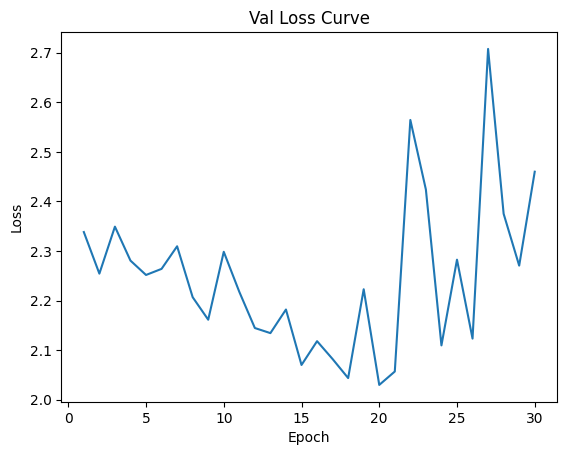

Finished Training Teacher
Teacher weights and architecture saved and exported for lambda: 0


In [25]:
# Initialize the dictionary for results
lambda_results = {}

# Loop for training the teacher model with different lambda values
for i in lmda_list:
    # Reset the teacher model for each lambda
    teacher_model = torchvision.models.resnet34(weights=None).to(device)
    teacher_model.fc = nn.Linear(512, num_classes)
    teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=best_lr_teacher)
    
    # Initialize the adversary for the teacher
    adv = Adversary()
    teacher_optimizer_adv = optim.Adam(adv.parameters(), lr=best_lr_teacher)

    pretrain_teacher(teacher_model, trainloader, criterion_clf, teacher_optimizer, device, epochs_pretrain)
    pretrain_adversary(adv, student_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    # Train the teacher model with adversarial training
    teacher_mean_abs_val_disparity = train_teacher(teacher_model, adv, trainloader, criterion_clf, adv_criterion, teacher_optimizer, teacher_optimizer_adv, device, epochs, i, patience=patience_teacher)

    # Save the teacher model and its state
    torch.save(teacher_model.state_dict(), f'teacher_model_weights_ckd_wider_lambda{i}.pth')
    torch.save(teacher_model, f'teacher_model_ckd_wider_lambda{i}.pth')
    print('Teacher weights and architecture saved and exported for lambda:', i)

    # Store the teacher results in the dictionary
    lambda_results[i] = {
        'teacher_mean_abs_val_disparity': teacher_mean_abs_val_disparity
    }


In [ ]:
# Loop for training the student model with different lambda values
for i in lmda_list:
    # load teacher model with lambda 0
    teacher_model = torch.load('teacher_model_ckd_wider_lambda0.pth')
    teacher_model.load_state_dict(torch.load('teacher_model_weights_ckd_wider_lambda0.pth'))
    teacher_model = teacher_model.to(device)
    
    # Reset the student model for each lambda
    student_model = torchvision.models.resnet18(weights=None).to(device)
    student_model.fc = nn.Linear(512, num_classes)
    student_optimizer = optim.Adam(student_model.parameters(), lr=best_lr_student)
    student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)

    adv = Adversary()
    student_optimizer_adv = optim.Adam(adv.parameters(), lr=best_lr_student)

    pretrain_student(student_model, teacher_model, trainloader, criterion_clf, student_optimizer, device, alpha, temperature, epochs_pretrain)
    pretrain_adversary(adv, teacher_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    student_mean_abs_val_disparity = train_student_with_distillation_disparity(student_model, teacher_model, adv, trainloader, testloader, criterion_clf, adv_criterion, student_optimizer, device, alpha, temperature, epochs, lmda=0, patience=patience_student, optimizer_adv=student_optimizer_adv)

    torch.save(student_model.state_dict(), f'student_model_weights_ckd_wider_lambda{i}.pth')
    torch.save(student_model, f'student_model_ckd_wider_lambda{i}.pth')
    print('Student weights and architecture saved and exported for lambda:', i)

    # Update the dictionary with the student results
    lambda_results[i].update({
        'student_mean_abs_val_disparity': student_mean_abs_val_disparity
    })


100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:55<00:00,  4.45s/it]


*******Epoch 0: loss - 0.43815056865031904


100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it]


*******Epoch 1: loss - 0.3710183810729247


100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:54<00:00,  4.41s/it]


*******Epoch 2: loss - 0.34297792040384734


100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:55<00:00,  4.43s/it]


Average Pretrain Adversary epoch loss:  0.38575901893469006


100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it]


Average Pretrain Adversary epoch loss:  0.38889855490281033


100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:55<00:00,  4.44s/it]


Average Pretrain Adversary epoch loss:  0.38502874282690197


100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.26s/it]


Average Adversary epoch loss: 0.28597814532426685


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.02s/it]


*****Epoch 1/300*****
*****Train Loss:  0.324368 Val Loss:  0.366515*****
*****Validation Accuracy: 33.85%*****
*****Total Avg Disparity: 0.11308453844241106*****

Class Team_Sports: Recall Difference = 0.0673089274245342
Class Celebration: Recall Difference = -0.06511627906976747
Class Parade: Recall Difference = 0.0715141146278871
Class Waiter_Or_Waitress: Recall Difference = 0.03236245954692557
Class Individual_Sports: Recall Difference = -0.058193245494472245
Class Surgeons: Recall Difference = 0.02439024390243903
Class Spa: Recall Difference = -0.44000000000000006
Class Law_Enforcement: Recall Difference = 0.1373873873873874
Class Business: Recall Difference = -0.1851061559799423
Class Dresses: Recall Difference = -0.20731707317073172
Class Water_Activities: Recall Difference = 0.07459459459459461
Class Picnic: Recall Difference = 0.2181818181818182
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.004306808859721081
Class Performance_And_Entertainment: 

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:49<00:00,  4.22s/it]


Average Adversary epoch loss: 0.27536072582006454


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.97s/it]


*****Epoch 2/300*****
*****Train Loss:  0.307486 Val Loss:  0.423448*****
*****Validation Accuracy: 32.61%*****
*****Total Avg Disparity: 0.11429138864094947*****

Class Team_Sports: Recall Difference = 0.11614409995912883
Class Celebration: Recall Difference = -0.03953488372093025
Class Parade: Recall Difference = -0.04123182207014553
Class Waiter_Or_Waitress: Recall Difference = 0.11003236245954695
Class Individual_Sports: Recall Difference = -0.082651824928063
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.27999999999999997
Class Law_Enforcement: Recall Difference = 0.2332332332332332
Class Business: Recall Difference = -0.07948362317294355
Class Dresses: Recall Difference = -0.3340108401084011
Class Water_Activities: Recall Difference = 0.03243243243243232
Class Picnic: Recall Difference = -0.18181818181818182
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.001435602953240361
Class Performance_And_Entertainment: Recall Differe

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:49<00:00,  4.21s/it]


Average Adversary epoch loss: 0.2427281175668423


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.99s/it]


*****Epoch 3/300*****
*****Train Loss:  0.288033 Val Loss:  0.381367*****
*****Validation Accuracy: 32.50%*****
*****Total Avg Disparity: 0.1410348256509261*****

Class Team_Sports: Recall Difference = 0.0770362585391487
Class Celebration: Recall Difference = -0.041860465116279166
Class Parade: Recall Difference = 0.02087254063301963
Class Waiter_Or_Waitress: Recall Difference = 0.04207119741100318
Class Individual_Sports: Recall Difference = 0.04448735423292438
Class Surgeons: Recall Difference = 0.11677753141167771
Class Spa: Recall Difference = -0.6
Class Law_Enforcement: Recall Difference = 0.2562562562562563
Class Business: Recall Difference = -0.16131441374159827
Class Dresses: Recall Difference = -0.20325203252032514
Class Water_Activities: Recall Difference = 0.04918918918918924
Class Picnic: Recall Difference = 0.3818181818181819
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.012305168170631669
Class Performance_And_Entertainment: Recall Differenc

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:49<00:00,  4.23s/it]


Average Adversary epoch loss: 0.22498392256406638


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  2.00s/it]


*****Epoch 4/300*****
*****Train Loss:  0.279286 Val Loss:  0.311130*****
*****Validation Accuracy: 41.13%*****
*****Total Avg Disparity: 0.1259258626025249*****

Class Team_Sports: Recall Difference = 0.1403748467332281
Class Celebration: Recall Difference = -0.011627906976744151
Class Parade: Recall Difference = -0.02680353578557182
Class Waiter_Or_Waitress: Recall Difference = -0.029588534442903325
Class Individual_Sports: Recall Difference = -0.0320308950477054
Class Surgeons: Recall Difference = 0.014042867701404338
Class Spa: Recall Difference = -0.5
Class Law_Enforcement: Recall Difference = 0.2777777777777778
Class Business: Recall Difference = -0.20655073082257544
Class Dresses: Recall Difference = -0.32655826558265577
Class Water_Activities: Recall Difference = 0.12205405405405406
Class Picnic: Recall Difference = 0.12727272727272726
Class Rescue: Recall Difference = 0.02531645569620253
Class Cheering: Recall Difference = 0.02255947497949138
Class Performance_And_Entertainmen

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.24s/it]


Average Adversary epoch loss: 0.22865406882304412


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.97s/it]


*****Epoch 5/300*****
*****Train Loss:  0.263582 Val Loss:  0.419805*****
*****Validation Accuracy: 33.62%*****
*****Total Avg Disparity: 0.08980125250694834*****

Class Team_Sports: Recall Difference = 0.1414958836924155
Class Celebration: Recall Difference = -0.06046511627906977
Class Parade: Recall Difference = 0.0029654975762760244
Class Waiter_Or_Waitress: Recall Difference = -0.0036985668053629295
Class Individual_Sports: Recall Difference = -0.06781008632439811
Class Surgeons: Recall Difference = 0.04360679970436071
Class Spa: Recall Difference = -0.32
Class Law_Enforcement: Recall Difference = 0.2014514514514515
Class Business: Recall Difference = -0.22927557879014193
Class Dresses: Recall Difference = -0.18157181571815723
Class Water_Activities: Recall Difference = -0.018918918918918892
Class Picnic: Recall Difference = -0.03636363636363632
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.01743232157506152
Class Performance_And_Entertainment: Recall 

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.30s/it]


Average Adversary epoch loss: 0.22883570939302444


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.02s/it]


*****Epoch 6/300*****
*****Train Loss:  0.255776 Val Loss:  0.304202*****
*****Validation Accuracy: 39.39%*****
*****Total Avg Disparity: 0.08610411154344469*****

Class Team_Sports: Recall Difference = 0.06887370818006644
Class Celebration: Recall Difference = -0.009302325581395376
Class Parade: Recall Difference = 0.007470772740233889
Class Waiter_Or_Waitress: Recall Difference = -0.07073509015256588
Class Individual_Sports: Recall Difference = -0.10559594123883098
Class Surgeons: Recall Difference = 0.08573540280857356
Class Spa: Recall Difference = -0.08
Class Law_Enforcement: Recall Difference = 0.23098098098098097
Class Business: Recall Difference = -0.15544649525232052
Class Dresses: Recall Difference = -0.2547425474254743
Class Water_Activities: Recall Difference = 0.04529729729729731
Class Picnic: Recall Difference = -0.054545454545454564
Class Rescue: Recall Difference = 0.005316455696202531
Class Cheering: Recall Difference = 0.05229696472518457
Class Performance_And_Enterta

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:49<00:00,  4.21s/it]


Average Adversary epoch loss: 0.21307819680525705


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.01s/it]


*****Epoch 7/300*****
*****Train Loss:  0.248171 Val Loss:  0.312611*****
*****Validation Accuracy: 41.07%*****
*****Total Avg Disparity: 0.10649278529747422*****

Class Team_Sports: Recall Difference = 0.15787937175220434
Class Celebration: Recall Difference = 2.7755575615628914e-17
Class Parade: Recall Difference = -0.007470772740233778
Class Waiter_Or_Waitress: Recall Difference = -0.06934812760055475
Class Individual_Sports: Recall Difference = -0.07969862183855814
Class Surgeons: Recall Difference = 0.12934220251293413
Class Spa: Recall Difference = -0.33999999999999997
Class Law_Enforcement: Recall Difference = 0.1611611611611612
Class Business: Recall Difference = -0.17667769124079807
Class Dresses: Recall Difference = -0.23644986449864497
Class Water_Activities: Recall Difference = 0.049513513513513574
Class Picnic: Recall Difference = 0.10909090909090902
Class Rescue: Recall Difference = -0.007341772151898735
Class Cheering: Recall Difference = 0.0008203445447087648
Class Perf

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.26s/it]


Average Adversary epoch loss: 0.2091072557064203


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.03s/it]


*****Epoch 8/300*****
*****Train Loss:  0.234113 Val Loss:  0.306049*****
*****Validation Accuracy: 40.32%*****
*****Total Avg Disparity: 0.10438951958266499*****

Class Team_Sports: Recall Difference = 0.08789630408127513
Class Celebration: Recall Difference = -0.05348837209302329
Class Parade: Recall Difference = -0.07231251782149983
Class Waiter_Or_Waitress: Recall Difference = -0.07859454461396209
Class Individual_Sports: Recall Difference = -0.015068908072088438
Class Surgeons: Recall Difference = 0.08130081300813014
Class Spa: Recall Difference = -0.18
Class Law_Enforcement: Recall Difference = 0.2917917917917918
Class Business: Recall Difference = -0.1181051957750987
Class Dresses: Recall Difference = -0.3265582655826559
Class Water_Activities: Recall Difference = 0.08010810810810814
Class Picnic: Recall Difference = 0.16363636363636364
Class Rescue: Recall Difference = 0.02329113924050632
Class Cheering: Recall Difference = -0.03322395406070551
Class Performance_And_Entertainme

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.30s/it]


Average Adversary epoch loss: 0.18617431360941666


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  2.00s/it]


*****Epoch 9/300*****
*****Train Loss:  0.222962 Val Loss:  0.305202*****
*****Validation Accuracy: 41.62%*****
*****Total Avg Disparity: 0.10764908219379471*****

Class Team_Sports: Recall Difference = 0.13481637181059136
Class Celebration: Recall Difference = 0.03488372093023254
Class Parade: Recall Difference = -0.003934987168520032
Class Waiter_Or_Waitress: Recall Difference = -0.0998613037447989
Class Individual_Sports: Recall Difference = -0.06360745115856437
Class Surgeons: Recall Difference = 0.09238728750923872
Class Spa: Recall Difference = -0.16
Class Law_Enforcement: Recall Difference = 0.15915915915915924
Class Business: Recall Difference = -0.0301931078630108
Class Dresses: Recall Difference = -0.559620596205962
Class Water_Activities: Recall Difference = 0.11156756756756758
Class Picnic: Recall Difference = -0.05454545454545451
Class Rescue: Recall Difference = -0.04405063291139241
Class Cheering: Recall Difference = -0.04470877768662837
Class Performance_And_Entertainme

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.24s/it]


Average Adversary epoch loss: 0.18839136740336052


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.03s/it]


*****Epoch 10/300*****
*****Train Loss:  0.218768 Val Loss:  0.313056*****
*****Validation Accuracy: 40.38%*****
*****Total Avg Disparity: 0.1279135871783979*****

Class Team_Sports: Recall Difference = 0.12887254043323398
Class Celebration: Recall Difference = 0.020930232558139417
Class Parade: Recall Difference = -0.023838038209295753
Class Waiter_Or_Waitress: Recall Difference = -0.045307443365695754
Class Individual_Sports: Recall Difference = -0.067810086324398
Class Surgeons: Recall Difference = 0.04360679970436071
Class Spa: Recall Difference = -0.62
Class Law_Enforcement: Recall Difference = 0.056306306306306286
Class Business: Recall Difference = -0.10690280593193219
Class Dresses: Recall Difference = -0.38414634146341464
Class Water_Activities: Recall Difference = 0.08918918918918922
Class Picnic: Recall Difference = 0.12727272727272732
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.016817063166529922
Class Performance_And_Entertainment: Recall Di

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.24s/it]


Average Adversary epoch loss: 0.20684462441847876


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.99s/it]


*****Epoch 11/300*****
*****Train Loss:  0.212858 Val Loss:  0.280047*****
*****Validation Accuracy: 42.66%*****
*****Total Avg Disparity: 0.12740764756498008*****

Class Team_Sports: Recall Difference = 0.16831902843463542
Class Celebration: Recall Difference = -0.025581395348837188
Class Parade: Recall Difference = -0.001482748788138033
Class Waiter_Or_Waitress: Recall Difference = -0.12112806287563577
Class Individual_Sports: Recall Difference = -0.033242465545963995
Class Surgeons: Recall Difference = 0.15373244641537318
Class Spa: Recall Difference = -0.27999999999999997
Class Law_Enforcement: Recall Difference = 0.2682682682682682
Class Business: Recall Difference = -0.1799850634802091
Class Dresses: Recall Difference = -0.44241192411924124
Class Water_Activities: Recall Difference = 0.13805405405405408
Class Picnic: Recall Difference = -0.09090909090909094
Class Rescue: Recall Difference = 0.03924050632911391
Class Cheering: Recall Difference = -0.01702214930270718
Class Perform

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.30s/it]


Average Adversary epoch loss: 0.18277389097672242


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.99s/it]


*****Epoch 12/300*****
*****Train Loss:  0.203335 Val Loss:  0.284436*****
*****Validation Accuracy: 41.67%*****
*****Total Avg Disparity: 0.16921915474210886*****

Class Team_Sports: Recall Difference = 0.1583931803584983
Class Celebration: Recall Difference = -0.05581395348837212
Class Parade: Recall Difference = -0.0523524379811805
Class Waiter_Or_Waitress: Recall Difference = -0.2112806287563569
Class Individual_Sports: Recall Difference = -0.042026351658337124
Class Surgeons: Recall Difference = 0.12342941611234295
Class Spa: Recall Difference = -0.4
Class Law_Enforcement: Recall Difference = 0.22547547547547545
Class Business: Recall Difference = -0.17891816920943132
Class Dresses: Recall Difference = -0.4315718157181572
Class Water_Activities: Recall Difference = 0.07243243243243258
Class Picnic: Recall Difference = 0.3636363636363637
Class Rescue: Recall Difference = -0.0020253164556962022
Class Cheering: Recall Difference = -0.06070549630844954
Class Performance_And_Entertainm

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.25s/it]


Average Adversary epoch loss: 0.17852682620286942


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.01s/it]


*****Epoch 13/300*****
*****Train Loss:  0.195700 Val Loss:  0.363390*****
*****Validation Accuracy: 42.63%*****
*****Total Avg Disparity: 0.1018230555219532*****

Class Team_Sports: Recall Difference = 0.2024405908798973
Class Celebration: Recall Difference = -0.037209302325581395
Class Parade: Recall Difference = -0.04123182207014553
Class Waiter_Or_Waitress: Recall Difference = -0.07998150716597319
Class Individual_Sports: Recall Difference = -0.1128275026503105
Class Surgeons: Recall Difference = 0.031042128603104235
Class Spa: Recall Difference = -0.36
Class Law_Enforcement: Recall Difference = 0.21221221221221215
Class Business: Recall Difference = -0.04758348447668839
Class Dresses: Recall Difference = -0.2825203252032521
Class Water_Activities: Recall Difference = -0.006810810810810808
Class Picnic: Recall Difference = 0.10909090909090902
Class Rescue: Recall Difference = -0.007341772151898733
Class Cheering: Recall Difference = -0.04922067268252665
Class Performance_And_Entert

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.27s/it]


Average Adversary epoch loss: 0.17718976334883615


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.99s/it]


*****Epoch 14/300*****
*****Train Loss:  0.190093 Val Loss:  0.321760*****
*****Validation Accuracy: 39.19%*****
*****Total Avg Disparity: 0.14089135316813206*****

Class Team_Sports: Recall Difference = 0.17747416360133117
Class Celebration: Recall Difference = -0.0651162790697675
Class Parade: Recall Difference = -0.005018534359851834
Class Waiter_Or_Waitress: Recall Difference = -0.15626444752658344
Class Individual_Sports: Recall Difference = 0.0009844010298347694
Class Surgeons: Recall Difference = 0.13599408721359946
Class Spa: Recall Difference = -0.64
Class Law_Enforcement: Recall Difference = 0.16841841841841848
Class Business: Recall Difference = -0.11938546890003199
Class Dresses: Recall Difference = -0.26829268292682923
Class Water_Activities: Recall Difference = -0.00421621621621604
Class Picnic: Recall Difference = -0.2545454545454545
Class Rescue: Recall Difference = 0.005316455696202531
Class Cheering: Recall Difference = -0.1216160787530763
Class Performance_And_Entert

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:52<00:00,  4.33s/it]


Average Adversary epoch loss: 0.17804695207339066


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.01s/it]


*****Epoch 15/300*****
*****Train Loss:  0.185967 Val Loss:  0.296866*****
*****Validation Accuracy: 42.16%*****
*****Total Avg Disparity: 0.11386168331711516*****

Class Team_Sports: Recall Difference = 0.10860045542126473
Class Celebration: Recall Difference = 0.0209302325581395
Class Parade: Recall Difference = 0.06655260906757926
Class Waiter_Or_Waitress: Recall Difference = -0.1465557096625058
Class Individual_Sports: Recall Difference = -0.12479176132061187
Class Surgeons: Recall Difference = 0.06799704360679973
Class Spa: Recall Difference = -0.18
Class Law_Enforcement: Recall Difference = 0.21121121121121122
Class Business: Recall Difference = -0.15800704150218708
Class Dresses: Recall Difference = -0.3766937669376694
Class Water_Activities: Recall Difference = 0.114054054054054
Class Picnic: Recall Difference = -0.10909090909090902
Class Rescue: Recall Difference = -0.024050632911392422
Class Cheering: Recall Difference = -0.06419196062346186
Class Performance_And_Entertainmen

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.29s/it]


Average Adversary epoch loss: 0.1735337279163874


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.02s/it]


*****Epoch 16/300*****
*****Train Loss:  0.177884 Val Loss:  0.303218*****
*****Validation Accuracy: 42.63%*****
*****Total Avg Disparity: 0.11070285625071165*****

Class Team_Sports: Recall Difference = 0.07453728031762707
Class Celebration: Recall Difference = 0.006976744186046491
Class Parade: Recall Difference = 0.023552894211576914
Class Waiter_Or_Waitress: Recall Difference = -0.16597318539066114
Class Individual_Sports: Recall Difference = -0.028396183552930554
Class Surgeons: Recall Difference = 0.13451589061345162
Class Spa: Recall Difference = -0.24
Class Law_Enforcement: Recall Difference = 0.2597597597597597
Class Business: Recall Difference = -0.09025925530779902
Class Dresses: Recall Difference = -0.42682926829268286
Class Water_Activities: Recall Difference = 0.01059459459459472
Class Picnic: Recall Difference = -0.09090909090909094
Class Rescue: Recall Difference = 0.02860759493670885
Class Cheering: Recall Difference = 0.011074651353568499
Class Performance_And_Enterta

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:49<00:00,  4.22s/it]


Average Adversary epoch loss: 0.16661393355864745


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.99s/it]


*****Epoch 17/300*****
*****Train Loss:  0.171876 Val Loss:  0.291028*****
*****Validation Accuracy: 42.74%*****
*****Total Avg Disparity: 0.1402696398869949*****

Class Team_Sports: Recall Difference = 0.12465697436795697
Class Celebration: Recall Difference = -0.0023255813953488302
Class Parade: Recall Difference = 0.04533789563729684
Class Waiter_Or_Waitress: Recall Difference = -0.14932963476652789
Class Individual_Sports: Recall Difference = -0.050469483568075124
Class Surgeons: Recall Difference = 0.18994826311899476
Class Spa: Recall Difference = -0.36
Class Law_Enforcement: Recall Difference = 0.24799799799799793
Class Business: Recall Difference = -0.05398485010135498
Class Dresses: Recall Difference = -0.49254742547425484
Class Water_Activities: Recall Difference = 0.07794594594594595
Class Picnic: Recall Difference = 0.10909090909090902
Class Rescue: Recall Difference = 0.09316455696202527
Class Cheering: Recall Difference = 0.009844134536505345
Class Performance_And_Enterta

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:52<00:00,  4.31s/it]


Average Adversary epoch loss: 0.1732367345919976


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  2.00s/it]


*****Epoch 18/300*****
*****Train Loss:  0.164583 Val Loss:  0.352901*****
*****Validation Accuracy: 40.72%*****
*****Total Avg Disparity: 0.0987125003872704*****

Class Team_Sports: Recall Difference = 0.07958194663396967
Class Celebration: Recall Difference = -0.07209302325581393
Class Parade: Recall Difference = -0.040889649272882855
Class Waiter_Or_Waitress: Recall Difference = -0.07535829865926941
Class Individual_Sports: Recall Difference = -0.011093442374678242
Class Surgeons: Recall Difference = 0.013303769401330351
Class Spa: Recall Difference = -0.32
Class Law_Enforcement: Recall Difference = 0.18668668668668664
Class Business: Recall Difference = -0.1472314093673317
Class Dresses: Recall Difference = -0.2378048780487805
Class Water_Activities: Recall Difference = -0.0892972972972973
Class Picnic: Recall Difference = -0.1636363636363637
Class Rescue: Recall Difference = -0.0020253164556962022
Class Cheering: Recall Difference = 0.04142739950779326
Class Performance_And_Entert

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:49<00:00,  4.22s/it]


Average Adversary epoch loss: 0.16789605583135897


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  2.00s/it]


*****Epoch 19/300*****
*****Train Loss:  0.162112 Val Loss:  0.278485*****
*****Validation Accuracy: 43.20%*****
*****Total Avg Disparity: 0.11124497969699856*****

Class Team_Sports: Recall Difference = 0.11797746248613294
Class Celebration: Recall Difference = -0.06046511627906974
Class Parade: Recall Difference = 0.057827202737382455
Class Waiter_Or_Waitress: Recall Difference = -0.036523347202958856
Class Individual_Sports: Recall Difference = -0.006322883537785928
Class Surgeons: Recall Difference = 0.12342941611234298
Class Spa: Recall Difference = -0.16
Class Law_Enforcement: Recall Difference = 0.3150650650650651
Class Business: Recall Difference = -0.005227781926811115
Class Dresses: Recall Difference = -0.19512195121951217
Class Water_Activities: Recall Difference = 0.03654054054054051
Class Picnic: Recall Difference = 0.2727272727272727
Class Rescue: Recall Difference = 0.0551898734177215
Class Cheering: Recall Difference = -0.022764561115668602
Class Performance_And_Enterta

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.24s/it]


Average Adversary epoch loss: 0.1646690947505144


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  2.00s/it]


*****Epoch 20/300*****
*****Train Loss:  0.152381 Val Loss:  0.306221*****
*****Validation Accuracy: 42.02%*****
*****Total Avg Disparity: 0.12471495543145532*****

Class Team_Sports: Recall Difference = 0.14088865533952238
Class Celebration: Recall Difference = 0.05116279069767449
Class Parade: Recall Difference = -0.10544625035642996
Class Waiter_Or_Waitress: Recall Difference = -0.033749422098936666
Class Individual_Sports: Recall Difference = -0.00034075420263512957
Class Surgeons: Recall Difference = 0.056910569105691144
Class Spa: Recall Difference = -0.36
Class Law_Enforcement: Recall Difference = 0.24124124124124113
Class Business: Recall Difference = -0.11426437640029873
Class Dresses: Recall Difference = -0.5094850948509486
Class Water_Activities: Recall Difference = 0.009513513513513538
Class Picnic: Recall Difference = -0.16363636363636364
Class Rescue: Recall Difference = 0.05063291139240506
Class Cheering: Recall Difference = -0.048400328137817875
Class Performance_And_En

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.24s/it]


Average Adversary epoch loss: 0.16309296626311082


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.98s/it]


*****Epoch 21/300*****
*****Train Loss:  0.147717 Val Loss:  0.281574*****
*****Validation Accuracy: 43.35%*****
*****Total Avg Disparity: 0.10943144326970189*****

Class Team_Sports: Recall Difference = 0.09121270508553747
Class Celebration: Recall Difference = -0.12558139534883722
Class Parade: Recall Difference = -0.0537781579697747
Class Waiter_Or_Waitress: Recall Difference = 0.000462320850670328
Class Individual_Sports: Recall Difference = -0.06599273057701044
Class Surgeons: Recall Difference = 0.17073170731707318
Class Spa: Recall Difference = -0.42000000000000004
Class Law_Enforcement: Recall Difference = 0.10885885885885885
Class Business: Recall Difference = -0.13144137415982082
Class Dresses: Recall Difference = -0.35975609756097565
Class Water_Activities: Recall Difference = 0.017189189189189213
Class Picnic: Recall Difference = -0.018181818181818132
Class Rescue: Recall Difference = 0.02708860759493681
Class Cheering: Recall Difference = -0.03712059064807216
Class Perform

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:49<00:00,  4.23s/it]


Average Adversary epoch loss: 0.16428779294857612


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  2.00s/it]


*****Epoch 22/300*****
*****Train Loss:  0.142653 Val Loss:  0.296529*****
*****Validation Accuracy: 41.96%*****
*****Total Avg Disparity: 0.11424040976432843*****

Class Team_Sports: Recall Difference = 0.14991533835464466
Class Celebration: Recall Difference = -0.016279069767441867
Class Parade: Recall Difference = -0.009637867122896993
Class Waiter_Or_Waitress: Recall Difference = -0.10171058714748027
Class Individual_Sports: Recall Difference = -0.036990761774950864
Class Surgeons: Recall Difference = 0.0753880266075389
Class Spa: Recall Difference = -0.62
Class Law_Enforcement: Recall Difference = 0.18693693693693697
Class Business: Recall Difference = -0.00821508588498876
Class Dresses: Recall Difference = -0.39972899728997285
Class Water_Activities: Recall Difference = -0.009837837837837926
Class Picnic: Recall Difference = -0.10909090909090907
Class Rescue: Recall Difference = 0.010632911392405062
Class Cheering: Recall Difference = -0.012100082034454479
Class Performance_And_E

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.30s/it]


Average Adversary epoch loss: 0.1629847758091413


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]


*****Epoch 23/300*****
*****Train Loss:  0.138728 Val Loss:  0.291481*****
*****Validation Accuracy: 43.12%*****
*****Total Avg Disparity: 0.13178035125333132*****

Class Team_Sports: Recall Difference = 0.142161499386933
Class Celebration: Recall Difference = -0.07209302325581396
Class Parade: Recall Difference = -0.1057313943541488
Class Waiter_Or_Waitress: Recall Difference = -0.1950993989828941
Class Individual_Sports: Recall Difference = -0.11006360745115851
Class Surgeons: Recall Difference = 0.10495195861049514
Class Spa: Recall Difference = -0.5599999999999999
Class Law_Enforcement: Recall Difference = 0.11736736736736733
Class Business: Recall Difference = -0.1830790568654646
Class Dresses: Recall Difference = -0.3292682926829269
Class Water_Activities: Recall Difference = 0.024972972972973073
Class Picnic: Recall Difference = -0.03636363636363632
Class Rescue: Recall Difference = 0.047848101265822784
Class Cheering: Recall Difference = -0.018662838392124695
Class Performance_

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:49<00:00,  4.22s/it]


Average Adversary epoch loss: 0.16328692550842577


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.98s/it]


*****Epoch 24/300*****
*****Train Loss:  0.131491 Val Loss:  0.328035*****
*****Validation Accuracy: 40.89%*****
*****Total Avg Disparity: 0.1062372864104608*****

Class Team_Sports: Recall Difference = 0.08727739826005709
Class Celebration: Recall Difference = -0.05116279069767442
Class Parade: Recall Difference = -0.018591388651268914
Class Waiter_Or_Waitress: Recall Difference = -0.07165973185390662
Class Individual_Sports: Recall Difference = -0.1141526578827805
Class Surgeons: Recall Difference = 0.11677753141167782
Class Spa: Recall Difference = -0.22000000000000003
Class Law_Enforcement: Recall Difference = 0.10385385385385384
Class Business: Recall Difference = -0.06774778619438813
Class Dresses: Recall Difference = -0.4024390243902439
Class Water_Activities: Recall Difference = -0.004756756756756686
Class Picnic: Recall Difference = -0.21818181818181817
Class Rescue: Recall Difference = 0.02531645569620253
Class Cheering: Recall Difference = -0.038146021328958196
Class Perform

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.24s/it]


Average Adversary epoch loss: 0.16275223745749548


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.99s/it]


*****Epoch 25/300*****
*****Train Loss:  0.129997 Val Loss:  0.302919*****
*****Validation Accuracy: 38.64%*****
*****Total Avg Disparity: 0.13491286111043072*****

Class Team_Sports: Recall Difference = 0.07141939627488758
Class Celebration: Recall Difference = -0.03720930232558137
Class Parade: Recall Difference = -0.0284573709723408
Class Waiter_Or_Waitress: Recall Difference = -0.10078594544613961
Class Individual_Sports: Recall Difference = -0.04013327275480838
Class Surgeons: Recall Difference = 0.1411677753141168
Class Spa: Recall Difference = -0.3
Class Law_Enforcement: Recall Difference = 0.1661661661661662
Class Business: Recall Difference = -0.0761762509335325
Class Dresses: Recall Difference = -0.5121951219512195
Class Water_Activities: Recall Difference = 0.0514594594594594
Class Picnic: Recall Difference = -0.38181818181818183
Class Rescue: Recall Difference = -0.006075949367088593
Class Cheering: Recall Difference = -0.005537325676784277
Class Performance_And_Entertainme

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.29s/it]


Average Adversary epoch loss: 0.1605599236029845


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.96s/it]


*****Epoch 26/300*****
*****Train Loss:  0.125914 Val Loss:  0.320954*****
*****Validation Accuracy: 42.94%*****
*****Total Avg Disparity: 0.14097175551604668*****

Class Team_Sports: Recall Difference = 0.14171775559058786
Class Celebration: Recall Difference = -0.025581395348837216
Class Parade: Recall Difference = 0.03604220131166236
Class Waiter_Or_Waitress: Recall Difference = -0.1317614424410541
Class Individual_Sports: Recall Difference = -0.08541572012721499
Class Surgeons: Recall Difference = 0.17812269031781233
Class Spa: Recall Difference = -0.44000000000000006
Class Law_Enforcement: Recall Difference = 0.20020020020020024
Class Business: Recall Difference = -0.057292222340766086
Class Dresses: Recall Difference = -0.31097560975609756
Class Water_Activities: Recall Difference = 0.09643243243243249
Class Picnic: Recall Difference = 0.2727272727272728
Class Rescue: Recall Difference = 0.009113924050632882
Class Cheering: Recall Difference = -0.06788351107465135
Class Performan

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.27s/it]


Average Adversary epoch loss: 0.16821394230310732


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.99s/it]


*****Epoch 27/300*****
*****Train Loss:  0.119873 Val Loss:  0.326490*****
*****Validation Accuracy: 40.61%*****
*****Total Avg Disparity: 0.13261077294878612*****

Class Team_Sports: Recall Difference = 0.10832019618146804
Class Celebration: Recall Difference = -0.09302325581395349
Class Parade: Recall Difference = 0.04813230681494156
Class Waiter_Or_Waitress: Recall Difference = -0.19602404068423485
Class Individual_Sports: Recall Difference = -0.04675904891715893
Class Surgeons: Recall Difference = 0.08203991130820393
Class Spa: Recall Difference = -0.33999999999999997
Class Law_Enforcement: Recall Difference = 0.1816816816816817
Class Business: Recall Difference = -0.08460471567267686
Class Dresses: Recall Difference = -0.47425474254742556
Class Water_Activities: Recall Difference = 0.06994594594594605
Class Picnic: Recall Difference = 0.18181818181818188
Class Rescue: Recall Difference = 0.02531645569620253
Class Cheering: Recall Difference = 0.042247744052502034
Class Performance

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.28s/it]


Average Adversary epoch loss: 0.16512207457652459


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.02s/it]


*****Epoch 28/300*****
*****Train Loss:  0.117422 Val Loss:  0.316057*****
*****Validation Accuracy: 40.58%*****
*****Total Avg Disparity: 0.12278119026014958*****

Class Team_Sports: Recall Difference = 0.16787528463829038
Class Celebration: Recall Difference = 0.011627906976744096
Class Parade: Recall Difference = 0.03147989734816076
Class Waiter_Or_Waitress: Recall Difference = -0.17475728155339806
Class Individual_Sports: Recall Difference = -0.004240496743904365
Class Surgeons: Recall Difference = 0.14042867701404288
Class Spa: Recall Difference = -0.44000000000000006
Class Law_Enforcement: Recall Difference = 0.2985485485485486
Class Business: Recall Difference = -0.1239731142643764
Class Dresses: Recall Difference = -0.2621951219512195
Class Water_Activities: Recall Difference = 0.0023783783783785095
Class Picnic: Recall Difference = 0.1454545454545455
Class Rescue: Recall Difference = 0.03797468354430379
Class Cheering: Recall Difference = -0.02666119770303528
Class Performance

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.23s/it]


Average Adversary epoch loss: 0.16493786011750883


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.01s/it]


*****Epoch 29/300*****
*****Train Loss:  0.110991 Val Loss:  0.287057*****
*****Validation Accuracy: 44.50%*****
*****Total Avg Disparity: 0.13555033258794652*****

Class Team_Sports: Recall Difference = 0.12773982600572176
Class Celebration: Recall Difference = -0.03488372093023255
Class Parade: Recall Difference = -0.0518391787852866
Class Waiter_Or_Waitress: Recall Difference = -0.04623208506703658
Class Individual_Sports: Recall Difference = -0.18181129789489636
Class Surgeons: Recall Difference = 0.1529933481152993
Class Spa: Recall Difference = -0.3
Class Law_Enforcement: Recall Difference = 0.2885385385385384
Class Business: Recall Difference = -0.11682492265016534
Class Dresses: Recall Difference = -0.4803523035230352
Class Water_Activities: Recall Difference = 0.03816216216216212
Class Picnic: Recall Difference = -0.18181818181818182
Class Rescue: Recall Difference = -0.07873417721518985
Class Cheering: Recall Difference = 0.013945857260049224
Class Performance_And_Entertainme

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.28s/it]


Average Adversary epoch loss: 0.16122613216821963


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.00s/it]


*****Epoch 30/300*****
*****Train Loss:  0.111206 Val Loss:  0.320545*****
*****Validation Accuracy: 42.48%*****
*****Total Avg Disparity: 0.13539676333077644*****

Class Team_Sports: Recall Difference = 0.08565423016290064
Class Celebration: Recall Difference = -0.08604651162790697
Class Parade: Recall Difference = -0.04237239806102089
Class Waiter_Or_Waitress: Recall Difference = -0.14147018030513175
Class Individual_Sports: Recall Difference = -0.048879297289111
Class Surgeons: Recall Difference = 0.05617147080561724
Class Spa: Recall Difference = -0.6599999999999999
Class Law_Enforcement: Recall Difference = 0.18943943943943942
Class Business: Recall Difference = -0.11533127067107646
Class Dresses: Recall Difference = -0.42682926829268286
Class Water_Activities: Recall Difference = 0.01913513513513515
Class Picnic: Recall Difference = 0.018181818181818077
Class Rescue: Recall Difference = -0.03468354430379747
Class Cheering: Recall Difference = 0.056193601312551356
Class Performanc

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.24s/it]


Average Adversary epoch loss: 0.16135166585445404


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.00s/it]


*****Epoch 31/300*****
*****Train Loss:  0.107306 Val Loss:  0.347015*****
*****Validation Accuracy: 39.25%*****
*****Total Avg Disparity: 0.10206318649573662*****

Class Team_Sports: Recall Difference = 0.14553628773281957
Class Celebration: Recall Difference = -0.018604651162790642
Class Parade: Recall Difference = 0.0532648987738808
Class Waiter_Or_Waitress: Recall Difference = -0.05409153952843271
Class Individual_Sports: Recall Difference = -0.001930940481599308
Class Surgeons: Recall Difference = 0.12269031781226905
Class Spa: Recall Difference = -0.45999999999999996
Class Law_Enforcement: Recall Difference = 0.28278278278278274
Class Business: Recall Difference = -0.05505174437213273
Class Dresses: Recall Difference = -0.15243902439024387
Class Water_Activities: Recall Difference = 0.055027027027027
Class Picnic: Recall Difference = -0.05454545454545451
Class Rescue: Recall Difference = 0.06177215189873425
Class Cheering: Recall Difference = -0.030147662018047583
Class Performan

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.27s/it]


Average Adversary epoch loss: 0.16818920637552554


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.98s/it]


*****Epoch 32/300*****
*****Train Loss:  0.104704 Val Loss:  0.316887*****
*****Validation Accuracy: 39.71%*****
*****Total Avg Disparity: 0.10808081704913758*****

Class Team_Sports: Recall Difference = 0.1357155368716062
Class Celebration: Recall Difference = -0.0697674418604651
Class Parade: Recall Difference = 0.012945537496435622
Class Waiter_Or_Waitress: Recall Difference = -0.17845584835876094
Class Individual_Sports: Recall Difference = -0.04384370740572474
Class Surgeons: Recall Difference = 0.09903917220990383
Class Spa: Recall Difference = -0.38
Class Law_Enforcement: Recall Difference = 0.22022022022022017
Class Business: Recall Difference = -0.02997972900885526
Class Dresses: Recall Difference = -0.31097560975609756
Class Water_Activities: Recall Difference = 0.02908108108108104
Class Picnic: Recall Difference = -0.14545454545454548
Class Rescue: Recall Difference = 0.025316455696202535
Class Cheering: Recall Difference = -0.007383100902378981
Class Performance_And_Enterta

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.27s/it]


Average Adversary epoch loss: 0.163146245938081


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]


*****Epoch 33/300*****
*****Train Loss:  0.100820 Val Loss:  0.332418*****
*****Validation Accuracy: 36.13%*****
*****Total Avg Disparity: 0.12721472041545157*****

Class Team_Sports: Recall Difference = 0.09117767268056287
Class Celebration: Recall Difference = -0.13953488372093026
Class Parade: Recall Difference = 0.016823495865412014
Class Waiter_Or_Waitress: Recall Difference = -0.140545538603791
Class Individual_Sports: Recall Difference = -0.051453884597910116
Class Surgeons: Recall Difference = 0.10421286031042132
Class Spa: Recall Difference = -0.3399999999999999
Class Law_Enforcement: Recall Difference = 0.15490490490490488
Class Business: Recall Difference = -0.024325189373733097
Class Dresses: Recall Difference = -0.16463414634146345
Class Water_Activities: Recall Difference = 0.021081081081081088
Class Picnic: Recall Difference = -0.4
Class Rescue: Recall Difference = -0.06810126582278483
Class Cheering: Recall Difference = 0.0680885972108286
Class Performance_And_Entertain

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.24s/it]


Average Adversary epoch loss: 0.1619825798731584


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.01s/it]


*****Epoch 34/300*****
*****Train Loss:  0.099944 Val Loss:  0.324058*****
*****Validation Accuracy: 44.30%*****
*****Total Avg Disparity: 0.1400751483354144*****

Class Team_Sports: Recall Difference = 0.12768143866409765
Class Celebration: Recall Difference = -0.020930232558139528
Class Parade: Recall Difference = 0.05218135158254916
Class Waiter_Or_Waitress: Recall Difference = -0.15996301433194637
Class Individual_Sports: Recall Difference = -0.019082235347569254
Class Surgeons: Recall Difference = 0.147819660014782
Class Spa: Recall Difference = -0.32
Class Law_Enforcement: Recall Difference = 0.25475475475475473
Class Business: Recall Difference = -0.1536327749919983
Class Dresses: Recall Difference = -0.4803523035230352
Class Water_Activities: Recall Difference = 0.02086486486486483
Class Picnic: Recall Difference = 0.19999999999999996
Class Rescue: Recall Difference = 0.03594936708860758
Class Cheering: Recall Difference = -0.05065627563576702
Class Performance_And_Entertainmen

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.29s/it]


Average Adversary epoch loss: 0.16094756642213234


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]


*****Epoch 35/300*****
*****Train Loss:  0.098242 Val Loss:  0.301758*****
*****Validation Accuracy: 43.75%*****
*****Total Avg Disparity: 0.10416078157047265*****

Class Team_Sports: Recall Difference = 0.0996788696210662
Class Celebration: Recall Difference = -0.041860465116279055
Class Parade: Recall Difference = 0.0034217279726260763
Class Waiter_Or_Waitress: Recall Difference = -0.05085529357374019
Class Individual_Sports: Recall Difference = -0.08503710434650924
Class Surgeons: Recall Difference = 0.02586844050258691
Class Spa: Recall Difference = -0.42000000000000004
Class Law_Enforcement: Recall Difference = 0.17717717717717707
Class Business: Recall Difference = -0.12066574202496538
Class Dresses: Recall Difference = -0.37804878048780494
Class Water_Activities: Recall Difference = -0.05091891891891892
Class Picnic: Recall Difference = 0.054545454545454564
Class Rescue: Recall Difference = 0.02531645569620253
Class Cheering: Recall Difference = -0.08080393765381458
Class Perfor

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.26s/it]


Average Adversary epoch loss: 0.16182494163513184


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  2.00s/it]


*****Epoch 36/300*****
*****Train Loss:  0.094125 Val Loss:  0.274078*****
*****Validation Accuracy: 43.78%*****
*****Total Avg Disparity: 0.11733703158327481*****

Class Team_Sports: Recall Difference = 0.11297950604308982
Class Celebration: Recall Difference = -0.09069767441860468
Class Parade: Recall Difference = 0.04100370687197036
Class Waiter_Or_Waitress: Recall Difference = -0.140545538603791
Class Individual_Sports: Recall Difference = -0.028585491443283317
Class Surgeons: Recall Difference = 0.12934220251293427
Class Spa: Recall Difference = -0.5599999999999999
Class Law_Enforcement: Recall Difference = 0.1048548548548549
Class Business: Recall Difference = -0.0926064227035101
Class Dresses: Recall Difference = -0.2547425474254743
Class Water_Activities: Recall Difference = -0.029081081081080984
Class Picnic: Recall Difference = -0.05454545454545462
Class Rescue: Recall Difference = 0.055189873417721524
Class Cheering: Recall Difference = -0.09598031173092703
Class Performance

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.30s/it]


Average Adversary epoch loss: 0.16097583507116026


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  2.00s/it]


*****Epoch 37/300*****
*****Train Loss:  0.092590 Val Loss:  0.306081*****
*****Validation Accuracy: 42.14%*****
*****Total Avg Disparity: 0.11060891851951686*****

Class Team_Sports: Recall Difference = 0.12190109184328857
Class Celebration: Recall Difference = 0.011627906976744179
Class Parade: Recall Difference = 0.05434844596521249
Class Waiter_Or_Waitress: Recall Difference = -0.17753120665742023
Class Individual_Sports: Recall Difference = -0.03907314856883226
Class Surgeons: Recall Difference = 0.05617147080561721
Class Spa: Recall Difference = -0.44000000000000006
Class Law_Enforcement: Recall Difference = 0.18768768768768773
Class Business: Recall Difference = -0.13090792702443185
Class Dresses: Recall Difference = -0.25
Class Water_Activities: Recall Difference = -0.04789189189189191
Class Picnic: Recall Difference = -0.018181818181818132
Class Rescue: Recall Difference = 0.0837974683544303
Class Cheering: Recall Difference = -0.052707136997538984
Class Performance_And_Entert

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:49<00:00,  4.20s/it]


Average Adversary epoch loss: 0.1615718861038868


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.99s/it]


*****Epoch 38/300*****
*****Train Loss:  0.091509 Val Loss:  0.271557*****
*****Validation Accuracy: 45.11%*****
*****Total Avg Disparity: 0.1621014304975097*****

Class Team_Sports: Recall Difference = 0.09429555672330237
Class Celebration: Recall Difference = -0.009302325581395376
Class Parade: Recall Difference = -0.12968349016253206
Class Waiter_Or_Waitress: Recall Difference = -0.22607489597780855
Class Individual_Sports: Recall Difference = -0.13395426321369086
Class Surgeons: Recall Difference = 0.07390983000739096
Class Spa: Recall Difference = -0.66
Class Law_Enforcement: Recall Difference = 0.2615115115115114
Class Business: Recall Difference = -0.13400192040968734
Class Dresses: Recall Difference = -0.524390243902439
Class Water_Activities: Recall Difference = 0.012540540540540601
Class Picnic: Recall Difference = 0.10909090909090902
Class Rescue: Recall Difference = 0.07594936708860758
Class Cheering: Recall Difference = -0.04327317473338807
Class Performance_And_Entertainm

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.28s/it]


Average Adversary epoch loss: 0.16075010826954475


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.01s/it]


*****Epoch 39/300*****
*****Train Loss:  0.090184 Val Loss:  0.281781*****
*****Validation Accuracy: 45.08%*****
*****Total Avg Disparity: 0.1459471040691449*****

Class Team_Sports: Recall Difference = 0.12072166754247682
Class Celebration: Recall Difference = -0.018604651162790697
Class Parade: Recall Difference = -0.08639863130881081
Class Waiter_Or_Waitress: Recall Difference = -0.13083680073971332
Class Individual_Sports: Recall Difference = -0.04762986521278212
Class Surgeons: Recall Difference = 0.17147080561714712
Class Spa: Recall Difference = -0.4
Class Law_Enforcement: Recall Difference = 0.22272272272272275
Class Business: Recall Difference = -0.2111383761869198
Class Dresses: Recall Difference = -0.34756097560975613
Class Water_Activities: Recall Difference = 0.07405405405405413
Class Picnic: Recall Difference = -0.4
Class Rescue: Recall Difference = -0.053417721518987354
Class Cheering: Recall Difference = -0.010049220672682546
Class Performance_And_Entertainment: Recall 

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.30s/it]


Average Adversary epoch loss: 0.16045540399276292


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.99s/it]


*****Epoch 40/300*****
*****Train Loss:  0.088576 Val Loss:  0.271338*****
*****Validation Accuracy: 43.32%*****
*****Total Avg Disparity: 0.12094664354558354*****

Class Team_Sports: Recall Difference = 0.12729608220937694
Class Celebration: Recall Difference = -0.0046511627906977715
Class Parade: Recall Difference = 0.07145708582834343
Class Waiter_Or_Waitress: Recall Difference = -0.09200184928340266
Class Individual_Sports: Recall Difference = -0.0441087384522188
Class Surgeons: Recall Difference = 0.15964523281596454
Class Spa: Recall Difference = -0.18
Class Law_Enforcement: Recall Difference = 0.1799299299299299
Class Business: Recall Difference = -0.12706710764963186
Class Dresses: Recall Difference = -0.25609756097560976
Class Water_Activities: Recall Difference = 0.09697297297297292
Class Picnic: Recall Difference = -0.16363636363636364
Class Rescue: Recall Difference = 0.07721518987341769
Class Cheering: Recall Difference = -0.14171452009844138
Class Performance_And_Entertai

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.26s/it]


Average Adversary epoch loss: 0.15892176444713885


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.99s/it]


*****Epoch 41/300*****
*****Train Loss:  0.087648 Val Loss:  0.262363*****
*****Validation Accuracy: 44.01%*****
*****Total Avg Disparity: 0.12308639166011763*****

Class Team_Sports: Recall Difference = 0.1065802534010627
Class Celebration: Recall Difference = -0.05813953488372095
Class Parade: Recall Difference = -0.01830624465355002
Class Waiter_Or_Waitress: Recall Difference = 0.019879796578825715
Class Individual_Sports: Recall Difference = -0.06580342268665762
Class Surgeons: Recall Difference = 0.12860310421286028
Class Spa: Recall Difference = -0.43999999999999995
Class Law_Enforcement: Recall Difference = 0.2294794794794795
Class Business: Recall Difference = -0.06700096020484364
Class Dresses: Recall Difference = -0.3766937669376694
Class Water_Activities: Recall Difference = 0.015027027027027018
Class Picnic: Recall Difference = -0.09090909090909088
Class Rescue: Recall Difference = 0.09189873417721517
Class Cheering: Recall Difference = -0.11115668580803933
Class Performanc

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:49<00:00,  4.20s/it]


Average Adversary epoch loss: 0.15768393071798179


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.02s/it]


*****Epoch 42/300*****
*****Train Loss:  0.087068 Val Loss:  0.305331*****
*****Validation Accuracy: 42.57%*****
*****Total Avg Disparity: 0.13434850670369516*****

Class Team_Sports: Recall Difference = 0.1326326852338413
Class Celebration: Recall Difference = -0.009302325581395349
Class Parade: Recall Difference = -0.06489877388080983
Class Waiter_Or_Waitress: Recall Difference = -0.19787332408691627
Class Individual_Sports: Recall Difference = -0.08905043162198989
Class Surgeons: Recall Difference = 0.13525498891352558
Class Spa: Recall Difference = -0.34
Class Law_Enforcement: Recall Difference = 0.1649149149149149
Class Business: Recall Difference = -0.15726021551264263
Class Dresses: Recall Difference = -0.34146341463414637
Class Water_Activities: Recall Difference = 0.008972972972973059
Class Picnic: Recall Difference = -0.10909090909090913
Class Rescue: Recall Difference = 0.06329113924050632
Class Cheering: Recall Difference = -0.04552912223133716
Class Performance_And_Enterta

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:49<00:00,  4.21s/it]


Average Adversary epoch loss: 0.15714807980335677


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.01s/it]


*****Epoch 43/300*****
*****Train Loss:  0.083838 Val Loss:  0.260271*****
*****Validation Accuracy: 47.22%*****
*****Total Avg Disparity: 0.14003660950593821*****

Class Team_Sports: Recall Difference = 0.0715128160214864
Class Celebration: Recall Difference = 0.027906976744186046
Class Parade: Recall Difference = -0.1079555175363559
Class Waiter_Or_Waitress: Recall Difference = -0.17244567730004634
Class Individual_Sports: Recall Difference = -0.04316219900045448
Class Surgeons: Recall Difference = 0.08721359940872131
Class Spa: Recall Difference = -0.42000000000000004
Class Law_Enforcement: Recall Difference = 0.19944944944944942
Class Business: Recall Difference = -0.14573775738824274
Class Dresses: Recall Difference = -0.49254742547425484
Class Water_Activities: Recall Difference = 0.016972972972973066
Class Picnic: Recall Difference = 0.16363636363636364
Class Rescue: Recall Difference = 0.06329113924050633
Class Cheering: Recall Difference = -0.051271534044298614
Class Performan

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:52<00:00,  4.31s/it]


Average Adversary epoch loss: 0.1581559651173078


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]


*****Epoch 44/300*****
*****Train Loss:  0.083583 Val Loss:  0.276459*****
*****Validation Accuracy: 41.59%*****
*****Total Avg Disparity: 0.13762452576882528*****

Class Team_Sports: Recall Difference = 0.11366847667425706
Class Celebration: Recall Difference = -0.03953488372093025
Class Parade: Recall Difference = -0.044995722840034225
Class Waiter_Or_Waitress: Recall Difference = -0.2339343504392048
Class Individual_Sports: Recall Difference = -0.05736029077691962
Class Surgeons: Recall Difference = 0.0746489283074648
Class Spa: Recall Difference = -0.4
Class Law_Enforcement: Recall Difference = 0.22472472472472482
Class Business: Recall Difference = -0.1153312706710764
Class Dresses: Recall Difference = -0.5304878048780488
Class Water_Activities: Recall Difference = 0.035675675675675644
Class Picnic: Recall Difference = 0.16363636363636364
Class Rescue: Recall Difference = 0.03797468354430379
Class Cheering: Recall Difference = -0.11054142739950784
Class Performance_And_Entertainme

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.30s/it]


Average Adversary epoch loss: 0.15724441065238073


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.96s/it]


*****Epoch 45/300*****
*****Train Loss:  0.082864 Val Loss:  0.292178*****
*****Validation Accuracy: 44.88%*****
*****Total Avg Disparity: 0.13552500773639015*****

Class Team_Sports: Recall Difference = 0.1150580954049163
Class Celebration: Recall Difference = -0.05581395348837204
Class Parade: Recall Difference = -0.03222127174222977
Class Waiter_Or_Waitress: Recall Difference = -0.3028201571890892
Class Individual_Sports: Recall Difference = 0.06913524155686818
Class Surgeons: Recall Difference = 0.16555801921655575
Class Spa: Recall Difference = -0.24
Class Law_Enforcement: Recall Difference = 0.16066066066066076
Class Business: Recall Difference = -0.12760055478502086
Class Dresses: Recall Difference = -0.5060975609756099
Class Water_Activities: Recall Difference = -0.0040000000000000036
Class Picnic: Recall Difference = -0.10909090909090907
Class Rescue: Recall Difference = 0.018481012658227824
Class Cheering: Recall Difference = -0.03609515996718622
Class Performance_And_Enterta

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.24s/it]


Average Adversary epoch loss: 0.16023279439944488


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.97s/it]


*****Epoch 46/300*****
*****Train Loss:  0.081916 Val Loss:  0.266685*****
*****Validation Accuracy: 42.86%*****
*****Total Avg Disparity: 0.15912505424964843*****

Class Team_Sports: Recall Difference = 0.03666725054008291
Class Celebration: Recall Difference = -0.05581395348837211
Class Parade: Recall Difference = -0.10191046478471627
Class Waiter_Or_Waitress: Recall Difference = -0.11927877947295423
Class Individual_Sports: Recall Difference = -0.03839164016356206
Class Surgeons: Recall Difference = 0.20177383592017742
Class Spa: Recall Difference = -0.5
Class Law_Enforcement: Recall Difference = 0.17592592592592582
Class Business: Recall Difference = -0.12482662968099867
Class Dresses: Recall Difference = -0.5792682926829269
Class Water_Activities: Recall Difference = 0.05448648648648646
Class Picnic: Recall Difference = -0.21818181818181814
Class Rescue: Recall Difference = 0.04126582278481013
Class Cheering: Recall Difference = -0.14376538146021323
Class Performance_And_Entertain

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.27s/it]


Average Adversary epoch loss: 0.1577758571276298


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.02s/it]


*****Epoch 47/300*****
*****Train Loss:  0.079230 Val Loss:  0.255065*****
*****Validation Accuracy: 47.01%*****
*****Total Avg Disparity: 0.16280618140317055*****

Class Team_Sports: Recall Difference = 0.11236060022187178
Class Celebration: Recall Difference = -0.04418604651162791
Class Parade: Recall Difference = 0.003421727972626132
Class Waiter_Or_Waitress: Recall Difference = -0.19879796578825704
Class Individual_Sports: Recall Difference = -0.07818415871573536
Class Surgeons: Recall Difference = 0.18994826311899485
Class Spa: Recall Difference = -0.6
Class Law_Enforcement: Recall Difference = 0.20745745745745747
Class Business: Recall Difference = -0.1347487463992318
Class Dresses: Recall Difference = -0.41463414634146345
Class Water_Activities: Recall Difference = 0.06799999999999995
Class Picnic: Recall Difference = 0.3818181818181819
Class Rescue: Recall Difference = -0.0007594936708860689
Class Cheering: Recall Difference = 0.03137817883511072
Class Performance_And_Entertain

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:52<00:00,  4.31s/it]


Average Adversary epoch loss: 0.15723696465675646


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]


*****Epoch 48/300*****
*****Train Loss:  0.080084 Val Loss:  0.266420*****
*****Validation Accuracy: 45.92%*****
*****Total Avg Disparity: 0.14917557512161772*****

Class Team_Sports: Recall Difference = 0.1526011560693643
Class Celebration: Recall Difference = -0.0767441860465117
Class Parade: Recall Difference = -0.023267750213857963
Class Waiter_Or_Waitress: Recall Difference = -0.18908922792417937
Class Individual_Sports: Recall Difference = -0.04887929728911122
Class Surgeons: Recall Difference = 0.16555801921655586
Class Spa: Recall Difference = -0.5999999999999999
Class Law_Enforcement: Recall Difference = 0.18868868868868877
Class Business: Recall Difference = -0.15341939613784283
Class Dresses: Recall Difference = -0.5365853658536587
Class Water_Activities: Recall Difference = -0.05394594594594587
Class Picnic: Recall Difference = -0.05454545454545451
Class Rescue: Recall Difference = 0.04658227848101264
Class Cheering: Recall Difference = -0.006357670221493042
Class Performan

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.31s/it]


Average Adversary epoch loss: 0.1567129555803079


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.98s/it]


*****Epoch 49/300*****
*****Train Loss:  0.080051 Val Loss:  0.263976*****
*****Validation Accuracy: 44.07%*****
*****Total Avg Disparity: 0.11550409093205*****

Class Team_Sports: Recall Difference = 0.08846850002919365
Class Celebration: Recall Difference = -0.032558139534883734
Class Parade: Recall Difference = 0.0009694895922440216
Class Waiter_Or_Waitress: Recall Difference = -0.1405455386037911
Class Individual_Sports: Recall Difference = -0.0537255792821445
Class Surgeons: Recall Difference = 0.19586104951958616
Class Spa: Recall Difference = -0.36
Class Law_Enforcement: Recall Difference = 0.1971971971971972
Class Business: Recall Difference = -0.0918595967139656
Class Dresses: Recall Difference = -0.510840108401084
Class Water_Activities: Recall Difference = 0.052000000000000046
Class Picnic: Recall Difference = 0.018181818181818188
Class Rescue: Recall Difference = 0.04329113924050633
Class Cheering: Recall Difference = 0.0006152584085314938
Class Performance_And_Entertainmen

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:53<00:00,  4.38s/it]


Average Adversary epoch loss: 0.15717322379350662


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.02s/it]


*****Epoch 50/300*****
*****Train Loss:  0.077620 Val Loss:  0.254290*****
*****Validation Accuracy: 44.10%*****
*****Total Avg Disparity: 0.1189925079756228*****

Class Team_Sports: Recall Difference = 0.09739008582939224
Class Celebration: Recall Difference = -0.023255813953488386
Class Parade: Recall Difference = -0.022469347020245167
Class Waiter_Or_Waitress: Recall Difference = -0.13083680073971332
Class Individual_Sports: Recall Difference = -0.03165227926699998
Class Surgeons: Recall Difference = 0.09238728750923875
Class Spa: Recall Difference = -0.44000000000000006
Class Law_Enforcement: Recall Difference = 0.27827827827827817
Class Business: Recall Difference = -0.01792382374906648
Class Dresses: Recall Difference = -0.4878048780487804
Class Water_Activities: Recall Difference = 0.0029189189189189335
Class Picnic: Recall Difference = 0.1636363636363637
Class Rescue: Recall Difference = -0.011392405063291144
Class Cheering: Recall Difference = -0.06378178835110754
Class Perfor

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:52<00:00,  4.31s/it]


Average Adversary epoch loss: 0.15679558595785728


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.99s/it]


*****Epoch 51/300*****
*****Train Loss:  0.077214 Val Loss:  0.260843*****
*****Validation Accuracy: 46.03%*****
*****Total Avg Disparity: 0.15460785964778168*****

Class Team_Sports: Recall Difference = 0.1592222806095639
Class Celebration: Recall Difference = -0.048837209302325546
Class Parade: Recall Difference = -0.0009124607927002981
Class Waiter_Or_Waitress: Recall Difference = -0.28432732316227466
Class Individual_Sports: Recall Difference = -0.10968499167045287
Class Surgeons: Recall Difference = 0.10495195861049525
Class Spa: Recall Difference = -0.44000000000000006
Class Law_Enforcement: Recall Difference = 0.20945945945945932
Class Business: Recall Difference = -0.1735836978555426
Class Dresses: Recall Difference = -0.46205962059620603
Class Water_Activities: Recall Difference = -0.038486486486486504
Class Picnic: Recall Difference = -0.2727272727272727
Class Rescue: Recall Difference = 0.04860759493670886
Class Cheering: Recall Difference = -0.04696472518457753
Class Perfor

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:52<00:00,  4.32s/it]


Average Adversary epoch loss: 0.15693959765709364


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.00s/it]


*****Epoch 52/300*****
*****Train Loss:  0.077416 Val Loss:  0.260599*****
*****Validation Accuracy: 45.71%*****
*****Total Avg Disparity: 0.12427242411392402*****

Class Team_Sports: Recall Difference = 0.16012144567057862
Class Celebration: Recall Difference = 0.016279069767441923
Class Parade: Recall Difference = 0.04562303963501574
Class Waiter_Or_Waitress: Recall Difference = -0.22607489597780855
Class Individual_Sports: Recall Difference = -0.034605482356504624
Class Surgeons: Recall Difference = 0.11677753141167771
Class Spa: Recall Difference = -0.33999999999999997
Class Law_Enforcement: Recall Difference = 0.17192192192192196
Class Business: Recall Difference = -0.11735836978555425
Class Dresses: Recall Difference = -0.3353658536585366
Class Water_Activities: Recall Difference = 0.016108108108108088
Class Picnic: Recall Difference = -0.09090909090909094
Class Rescue: Recall Difference = 0.07518987341772151
Class Cheering: Recall Difference = -0.03158326497128794
Class Performa

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.27s/it]


Average Adversary epoch loss: 0.15724916756153107


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.01s/it]


*****Epoch 53/300*****
*****Train Loss:  0.075815 Val Loss:  0.242563*****
*****Validation Accuracy: 46.52%*****
*****Total Avg Disparity: 0.13567763001774993*****

Class Team_Sports: Recall Difference = 0.08935598762188368
Class Celebration: Recall Difference = -0.018604651162790753
Class Parade: Recall Difference = -0.022697462218420283
Class Waiter_Or_Waitress: Recall Difference = -0.15996301433194637
Class Individual_Sports: Recall Difference = -0.05800393760411926
Class Surgeons: Recall Difference = 0.1840354767184036
Class Spa: Recall Difference = -0.44000000000000006
Class Law_Enforcement: Recall Difference = 0.2597597597597598
Class Business: Recall Difference = -0.07777659233969919
Class Dresses: Recall Difference = -0.5121951219512195
Class Water_Activities: Recall Difference = -0.02248648648648649
Class Picnic: Recall Difference = 0.14545454545454545
Class Rescue: Recall Difference = 0.04126582278481013
Class Cheering: Recall Difference = -0.03937653814602132
Class Performan

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.24s/it]


Average Adversary epoch loss: 0.1557044335282766


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.98s/it]


*****Epoch 54/300*****
*****Train Loss:  0.075531 Val Loss:  0.258532*****
*****Validation Accuracy: 44.04%*****
*****Total Avg Disparity: 0.15093770679717194*****

Class Team_Sports: Recall Difference = 0.10501547264553046
Class Celebration: Recall Difference = -0.020930232558139555
Class Parade: Recall Difference = -0.024066153407470703
Class Waiter_Or_Waitress: Recall Difference = -0.2048081368469718
Class Individual_Sports: Recall Difference = -0.04887929728911111
Class Surgeons: Recall Difference = 0.16555801921655575
Class Spa: Recall Difference = -0.38
Class Law_Enforcement: Recall Difference = 0.22297297297297292
Class Business: Recall Difference = -0.17539741811586484
Class Dresses: Recall Difference = -0.5060975609756098
Class Water_Activities: Recall Difference = -0.021405405405405364
Class Picnic: Recall Difference = -0.36363636363636365
Class Rescue: Recall Difference = 0.04658227848101264
Class Cheering: Recall Difference = -0.10910582444626746
Class Performance_And_Enter

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:49<00:00,  4.20s/it]


Average Adversary epoch loss: 0.15719878845489943


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.96s/it]


*****Epoch 55/300*****
*****Train Loss:  0.074427 Val Loss:  0.269586*****
*****Validation Accuracy: 45.74%*****
*****Total Avg Disparity: 0.15818695259071835*****

Class Team_Sports: Recall Difference = 0.12162083260349155
Class Celebration: Recall Difference = -0.15813953488372093
Class Parade: Recall Difference = 0.007755916737952673
Class Waiter_Or_Waitress: Recall Difference = -0.08414239482200642
Class Individual_Sports: Recall Difference = -0.14622141450855675
Class Surgeons: Recall Difference = 0.2505543237250555
Class Spa: Recall Difference = -0.6599999999999999
Class Law_Enforcement: Recall Difference = 0.24099099099099103
Class Business: Recall Difference = -0.1385895657740318
Class Dresses: Recall Difference = -0.39024390243902435
Class Water_Activities: Recall Difference = -0.018918918918918892
Class Picnic: Recall Difference = 0.12727272727272726
Class Rescue: Recall Difference = 0.02531645569620253
Class Cheering: Recall Difference = -0.05414273995077931
Class Performanc

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.27s/it]


Average Adversary epoch loss: 0.15597974852873728


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.00s/it]


*****Epoch 56/300*****
*****Train Loss:  0.074430 Val Loss:  0.260934*****
*****Validation Accuracy: 46.23%*****
*****Total Avg Disparity: 0.14745475431061428*****

Class Team_Sports: Recall Difference = 0.10596134757984466
Class Celebration: Recall Difference = 0.05348837209302326
Class Parade: Recall Difference = 0.03963501568291988
Class Waiter_Or_Waitress: Recall Difference = -0.18908922792417937
Class Individual_Sports: Recall Difference = -0.06190368014538844
Class Surgeons: Recall Difference = 0.16555801921655586
Class Spa: Recall Difference = -0.52
Class Law_Enforcement: Recall Difference = 0.21421421421421416
Class Business: Recall Difference = -0.18126533660514238
Class Dresses: Recall Difference = -0.4451219512195122
Class Water_Activities: Recall Difference = 0.026054054054054143
Class Picnic: Recall Difference = -0.18181818181818182
Class Rescue: Recall Difference = 0.0379746835443038
Class Cheering: Recall Difference = -0.05701394585726011
Class Performance_And_Entertainm

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.24s/it]


Average Adversary epoch loss: 0.1562582667057331


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  2.00s/it]


*****Epoch 57/300*****
*****Train Loss:  0.073533 Val Loss:  0.259364*****
*****Validation Accuracy: 46.20%*****
*****Total Avg Disparity: 0.12641514177821367*****

Class Team_Sports: Recall Difference = 0.08245460384188708
Class Celebration: Recall Difference = -0.0046511627906976605
Class Parade: Recall Difference = -0.0322783005417735
Class Waiter_Or_Waitress: Recall Difference = -0.2085067036523347
Class Individual_Sports: Recall Difference = -0.06391034378312876
Class Surgeons: Recall Difference = 0.11086474501108654
Class Spa: Recall Difference = -0.52
Class Law_Enforcement: Recall Difference = 0.23223223223223224
Class Business: Recall Difference = -0.08033713858956576
Class Dresses: Recall Difference = -0.39634146341463417
Class Water_Activities: Recall Difference = 0.050594594594594644
Class Picnic: Recall Difference = 0.054545454545454564
Class Rescue: Recall Difference = 0.05594936708860758
Class Cheering: Recall Difference = -0.004101722723543921
Class Performance_And_Enter

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.30s/it]


Average Adversary epoch loss: 0.15661785407708242


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.97s/it]


*****Epoch 58/300*****
*****Train Loss:  0.073226 Val Loss:  0.247090*****
*****Validation Accuracy: 44.07%*****
*****Total Avg Disparity: 0.12438687963544565*****

Class Team_Sports: Recall Difference = 0.061972324400069945
Class Celebration: Recall Difference = -0.11627906976744187
Class Parade: Recall Difference = 0.012147134302822993
Class Waiter_Or_Waitress: Recall Difference = -0.20850670365233465
Class Individual_Sports: Recall Difference = -0.11661366045736782
Class Surgeons: Recall Difference = 0.12860310421286036
Class Spa: Recall Difference = -0.32
Class Law_Enforcement: Recall Difference = 0.1296296296296296
Class Business: Recall Difference = -0.0752160460898324
Class Dresses: Recall Difference = -0.26693766937669383
Class Water_Activities: Recall Difference = 0.06497297297297311
Class Picnic: Recall Difference = 0.12727272727272726
Class Rescue: Recall Difference = 0.07189873417721517
Class Cheering: Recall Difference = -0.0652173913043479
Class Performance_And_Entertainm

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.27s/it]


Average Adversary epoch loss: 0.1578242417711478


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.97s/it]


*****Epoch 59/300*****
*****Train Loss:  0.071864 Val Loss:  0.273381*****
*****Validation Accuracy: 44.16%*****
*****Total Avg Disparity: 0.13410194585961882*****

Class Team_Sports: Recall Difference = 0.12229812576633392
Class Celebration: Recall Difference = -0.0767441860465117
Class Parade: Recall Difference = -0.028970630168235034
Class Waiter_Or_Waitress: Recall Difference = -0.21914008321775313
Class Individual_Sports: Recall Difference = -0.06887021051037412
Class Surgeons: Recall Difference = 0.09903917220990391
Class Spa: Recall Difference = -0.42000000000000004
Class Law_Enforcement: Recall Difference = 0.23448448448448445
Class Business: Recall Difference = -0.11607809666062091
Class Dresses: Recall Difference = -0.4329268292682927
Class Water_Activities: Recall Difference = -0.023891891891891892
Class Picnic: Recall Difference = -0.05454545454545451
Class Rescue: Recall Difference = 0.07594936708860758
Class Cheering: Recall Difference = -0.031788351107465154
Class Perfor

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.26s/it]


Average Adversary epoch loss: 0.1564680183163056


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.01s/it]


*****Epoch 60/300*****
*****Train Loss:  0.071720 Val Loss:  0.255251*****
*****Validation Accuracy: 45.51%*****
*****Total Avg Disparity: 0.1563022051843661*****

Class Team_Sports: Recall Difference = 0.12459858702633264
Class Celebration: Recall Difference = -0.05348837209302325
Class Parade: Recall Difference = -0.012090105503279103
Class Waiter_Or_Waitress: Recall Difference = -0.19787332408691638
Class Individual_Sports: Recall Difference = -0.10987429956080574
Class Surgeons: Recall Difference = 0.18403547671840362
Class Spa: Recall Difference = -0.42000000000000004
Class Law_Enforcement: Recall Difference = 0.20945945945945954
Class Business: Recall Difference = -0.18894697535474242
Class Dresses: Recall Difference = -0.535230352303523
Class Water_Activities: Recall Difference = -0.034594594594594574
Class Picnic: Recall Difference = -0.16363636363636364
Class Rescue: Recall Difference = -0.004050632911392418
Class Cheering: Recall Difference = -0.055578342904019695
Class Perfo

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.30s/it]


Average Adversary epoch loss: 0.15821370769005555


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.96s/it]


*****Epoch 61/300*****
*****Train Loss:  0.072477 Val Loss:  0.273670*****
*****Validation Accuracy: 45.19%*****
*****Total Avg Disparity: 0.1203813831192451*****

Class Team_Sports: Recall Difference = 0.13318152624511004
Class Celebration: Recall Difference = -0.03023255813953496
Class Parade: Recall Difference = -0.028970630168235034
Class Waiter_Or_Waitress: Recall Difference = -0.13962089690245033
Class Individual_Sports: Recall Difference = -0.08484779645615625
Class Surgeons: Recall Difference = 0.1840354767184036
Class Spa: Recall Difference = -0.33999999999999997
Class Law_Enforcement: Recall Difference = 0.2144644644644645
Class Business: Recall Difference = -0.23493011842526396
Class Dresses: Recall Difference = -0.3292682926829268
Class Water_Activities: Recall Difference = -0.036540540540540456
Class Picnic: Recall Difference = -0.036363636363636376
Class Rescue: Recall Difference = 0.06329113924050632
Class Cheering: Recall Difference = -0.01579163248564397
Class Performa

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.23s/it]


Average Adversary epoch loss: 0.15616866659659606


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.97s/it]


*****Epoch 62/300*****
*****Train Loss:  0.070553 Val Loss:  0.264491*****
*****Validation Accuracy: 44.68%*****
*****Total Avg Disparity: 0.1437420646280752*****

Class Team_Sports: Recall Difference = 0.12241490044958248
Class Celebration: Recall Difference = 0.01395348837209301
Class Parade: Recall Difference = -0.011576846307385202
Class Waiter_Or_Waitress: Recall Difference = -0.14748035136384646
Class Individual_Sports: Recall Difference = -0.013668029683477245
Class Surgeons: Recall Difference = 0.15890613451589064
Class Spa: Recall Difference = -0.36
Class Law_Enforcement: Recall Difference = 0.1839339339339341
Class Business: Recall Difference = -0.16003414061666488
Class Dresses: Recall Difference = -0.6219512195121951
Class Water_Activities: Recall Difference = -0.032972972972973025
Class Picnic: Recall Difference = 0.14545454545454545
Class Rescue: Recall Difference = 0.05063291139240506
Class Cheering: Recall Difference = -0.11648892534864645
Class Performance_And_Entertai

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.29s/it]


Average Adversary epoch loss: 0.1564883331839855


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.98s/it]


*****Epoch 63/300*****
*****Train Loss:  0.070892 Val Loss:  0.252123*****
*****Validation Accuracy: 47.10%*****
*****Total Avg Disparity: 0.15042453286103635*****

Class Team_Sports: Recall Difference = 0.11505809540491618
Class Celebration: Recall Difference = -0.06511627906976744
Class Parade: Recall Difference = -0.09267179925862568
Class Waiter_Or_Waitress: Recall Difference = -0.11326860841423947
Class Individual_Sports: Recall Difference = -0.03668786915038624
Class Surgeons: Recall Difference = 0.1537324464153733
Class Spa: Recall Difference = -0.38
Class Law_Enforcement: Recall Difference = 0.2309809809809809
Class Business: Recall Difference = -0.12226608343113199
Class Dresses: Recall Difference = -0.5914634146341463
Class Water_Activities: Recall Difference = 0.09891891891891902
Class Picnic: Recall Difference = 0.16363636363636364
Class Rescue: Recall Difference = 0.010632911392405062
Class Cheering: Recall Difference = -0.06419196062346186
Class Performance_And_Entertainm

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.24s/it]


Average Adversary epoch loss: 0.15555851849225852


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.99s/it]


*****Epoch 64/300*****
*****Train Loss:  0.069213 Val Loss:  0.247277*****
*****Validation Accuracy: 46.55%*****
*****Total Avg Disparity: 0.15307573601209717*****

Class Team_Sports: Recall Difference = 0.08335376890290191
Class Celebration: Recall Difference = -0.07209302325581401
Class Parade: Recall Difference = -0.027316794981465664
Class Waiter_Or_Waitress: Recall Difference = -0.2639852057327786
Class Individual_Sports: Recall Difference = -0.07314856883234899
Class Surgeons: Recall Difference = 0.19512195121951217
Class Spa: Recall Difference = -0.4
Class Law_Enforcement: Recall Difference = 0.1941941941941942
Class Business: Recall Difference = -0.17593086525125362
Class Dresses: Recall Difference = -0.5914634146341463
Class Water_Activities: Recall Difference = 0.09859459459459458
Class Picnic: Recall Difference = -0.0727272727272727
Class Rescue: Recall Difference = -0.011392405063291158
Class Cheering: Recall Difference = -0.0961853978671042
Class Performance_And_Entertainm

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.25s/it]


Average Adversary epoch loss: 0.15617468380011046


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.03s/it]


*****Epoch 65/300*****
*****Train Loss:  0.069057 Val Loss:  0.250996*****
*****Validation Accuracy: 47.30%*****
*****Total Avg Disparity: 0.11635634728516814*****

Class Team_Sports: Recall Difference = 0.09407368482513001
Class Celebration: Recall Difference = 0.05348837209302315
Class Parade: Recall Difference = -0.0842315369261476
Class Waiter_Or_Waitress: Recall Difference = -0.1114193250115581
Class Individual_Sports: Recall Difference = -0.04925791306981675
Class Surgeons: Recall Difference = 0.12934220251293427
Class Spa: Recall Difference = -0.33999999999999997
Class Law_Enforcement: Recall Difference = 0.19094094094094105
Class Business: Recall Difference = -0.12450656139976521
Class Dresses: Recall Difference = -0.4193766937669377
Class Water_Activities: Recall Difference = 0.026054054054054143
Class Picnic: Recall Difference = -0.09090909090909094
Class Rescue: Recall Difference = 0.0012658227848101195
Class Cheering: Recall Difference = 0.009023789991796483
Class Performan

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.24s/it]


Average Adversary epoch loss: 0.15516028954432562


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.99s/it]


*****Epoch 66/300*****
*****Train Loss:  0.068679 Val Loss:  0.263778*****
*****Validation Accuracy: 44.70%*****
*****Total Avg Disparity: 0.14635334599496488*****

Class Team_Sports: Recall Difference = 0.10777135517019909
Class Celebration: Recall Difference = -0.0023255813953488302
Class Parade: Recall Difference = -0.06353008269175942
Class Waiter_Or_Waitress: Recall Difference = -0.2376329172445677
Class Individual_Sports: Recall Difference = -0.10351355444494936
Class Surgeons: Recall Difference = 0.17738359201773832
Class Spa: Recall Difference = -0.5399999999999999
Class Law_Enforcement: Recall Difference = 0.20070070070070067
Class Business: Recall Difference = -0.046836658487143856
Class Dresses: Recall Difference = -0.225609756097561
Class Water_Activities: Recall Difference = -0.04562162162162153
Class Picnic: Recall Difference = 0.23636363636363633
Class Rescue: Recall Difference = 0.010632911392405069
Class Cheering: Recall Difference = -0.0061525840853158265
Class Perfor

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:49<00:00,  4.20s/it]


Average Adversary epoch loss: 0.15616100969222876


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.99s/it]


*****Epoch 67/300*****
*****Train Loss:  0.068496 Val Loss:  0.252669*****
*****Validation Accuracy: 46.58%*****
*****Total Avg Disparity: 0.15063308043638313*****

Class Team_Sports: Recall Difference = 0.09289426052431815
Class Celebration: Recall Difference = -0.016279069767441867
Class Parade: Recall Difference = -0.05566010835471913
Class Waiter_Or_Waitress: Recall Difference = -0.2454923717059639
Class Individual_Sports: Recall Difference = -0.05743601393306075
Class Surgeons: Recall Difference = 0.2143385070214339
Class Spa: Recall Difference = -0.13999999999999999
Class Law_Enforcement: Recall Difference = 0.24124124124124124
Class Business: Recall Difference = -0.15907393577296486
Class Dresses: Recall Difference = -0.6341463414634148
Class Water_Activities: Recall Difference = 0.03459459459459463
Class Picnic: Recall Difference = -0.14545454545454545
Class Rescue: Recall Difference = 0.061265822784810124
Class Cheering: Recall Difference = -0.05988515176374082
Class Performan

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.24s/it]


Average Adversary epoch loss: 0.15540901915385172


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.01s/it]


*****Epoch 68/300*****
*****Train Loss:  0.067634 Val Loss:  0.242609*****
*****Validation Accuracy: 45.22%*****
*****Total Avg Disparity: 0.13736960626208586*****

Class Team_Sports: Recall Difference = 0.13077596777018752
Class Celebration: Recall Difference = -0.05348837209302332
Class Parade: Recall Difference = -0.006900484744796098
Class Waiter_Or_Waitress: Recall Difference = -0.22699953767914932
Class Individual_Sports: Recall Difference = -0.05221111615932161
Class Surgeons: Recall Difference = 0.12269031781226898
Class Spa: Recall Difference = -0.41999999999999993
Class Law_Enforcement: Recall Difference = 0.15565565565565553
Class Business: Recall Difference = -0.1199189160354209
Class Dresses: Recall Difference = -0.5
Class Water_Activities: Recall Difference = 0.0020540540540540664
Class Picnic: Recall Difference = -0.23636363636363633
Class Rescue: Recall Difference = 0.06658227848101264
Class Cheering: Recall Difference = 0.0004101722723542922
Class Performance_And_Enter

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.23s/it]


Average Adversary epoch loss: 0.1551772178365634


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.98s/it]


*****Epoch 69/300*****
*****Train Loss:  0.067341 Val Loss:  0.259512*****
*****Validation Accuracy: 46.06%*****
*****Total Avg Disparity: 0.13175710501758717*****

Class Team_Sports: Recall Difference = 0.10383604834471893
Class Celebration: Recall Difference = 0.013953488372092981
Class Parade: Recall Difference = 0.0009694895922440216
Class Waiter_Or_Waitress: Recall Difference = -0.22884882108183074
Class Individual_Sports: Recall Difference = -0.08761169165530835
Class Surgeons: Recall Difference = 0.23798965262379893
Class Spa: Recall Difference = -0.54
Class Law_Enforcement: Recall Difference = 0.2042042042042041
Class Business: Recall Difference = -0.11202389843166544
Class Dresses: Recall Difference = -0.4207317073170732
Class Water_Activities: Recall Difference = 0.012540540540540601
Class Picnic: Recall Difference = -0.018181818181818132
Class Rescue: Recall Difference = 0.02860759493670885
Class Cheering: Recall Difference = -0.02522559474979494
Class Performance_And_Entert

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.26s/it]


Average Adversary epoch loss: 0.15502948142015016


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  2.00s/it]


*****Epoch 70/300*****
*****Train Loss:  0.067353 Val Loss:  0.261637*****
*****Validation Accuracy: 47.22%*****
*****Total Avg Disparity: 0.1379565951409624*****

Class Team_Sports: Recall Difference = 0.11977579260816251
Class Celebration: Recall Difference = -0.07441860465116279
Class Parade: Recall Difference = -0.03906472768748215
Class Waiter_Or_Waitress: Recall Difference = -0.21636615811373094
Class Individual_Sports: Recall Difference = -0.05334696350143875
Class Surgeons: Recall Difference = 0.1840354767184036
Class Spa: Recall Difference = -0.42000000000000004
Class Law_Enforcement: Recall Difference = 0.22972972972972971
Class Business: Recall Difference = -0.16131441374159822
Class Dresses: Recall Difference = -0.39024390243902446
Class Water_Activities: Recall Difference = -0.021621621621621512
Class Picnic: Recall Difference = -0.09090909090909094
Class Rescue: Recall Difference = 0.01721518987341772
Class Cheering: Recall Difference = -0.028096800656275678
Class Perform

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.26s/it]


Average Adversary epoch loss: 0.15615843064509904


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.00s/it]


*****Epoch 71/300*****
*****Train Loss:  0.067431 Val Loss:  0.257128*****
*****Validation Accuracy: 46.93%*****
*****Total Avg Disparity: 0.1411040824924684*****

Class Team_Sports: Recall Difference = 0.16820225375138664
Class Celebration: Recall Difference = -0.02790697674418602
Class Parade: Recall Difference = -0.055374964357000345
Class Waiter_Or_Waitress: Recall Difference = -0.13083680073971327
Class Individual_Sports: Recall Difference = -0.08484779645615625
Class Surgeons: Recall Difference = 0.16555801921655589
Class Spa: Recall Difference = -0.48
Class Law_Enforcement: Recall Difference = 0.1669169169169169
Class Business: Recall Difference = -0.22266083431131978
Class Dresses: Recall Difference = -0.3658536585365854
Class Water_Activities: Recall Difference = -0.05718918918918914
Class Picnic: Recall Difference = -0.12727272727272726
Class Rescue: Recall Difference = 0.061265822784810124
Class Cheering: Recall Difference = -0.11341263330598847
Class Performance_And_Enterta

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.25s/it]


Average Adversary epoch loss: 0.15595541092065665


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.00s/it]


*****Epoch 72/300*****
*****Train Loss:  0.067259 Val Loss:  0.255980*****
*****Validation Accuracy: 46.98%*****
*****Total Avg Disparity: 0.1545498256968049*****

Class Team_Sports: Recall Difference = 0.07123255678168972
Class Celebration: Recall Difference = -0.037209302325581395
Class Parade: Recall Difference = -0.05594525235243797
Class Waiter_Or_Waitress: Recall Difference = -0.2376329172445677
Class Individual_Sports: Recall Difference = -0.1384219294260185
Class Surgeons: Recall Difference = 0.17147080561714712
Class Spa: Recall Difference = -0.52
Class Law_Enforcement: Recall Difference = 0.17842842842842838
Class Business: Recall Difference = -0.15544649525232052
Class Dresses: Recall Difference = -0.573170731707317
Class Water_Activities: Recall Difference = 0.06054054054054059
Class Picnic: Recall Difference = -0.07272727272727275
Class Rescue: Recall Difference = -0.011392405063291158
Class Cheering: Recall Difference = -0.07588187038556196
Class Performance_And_Entertain

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:49<00:00,  4.21s/it]


Average Adversary epoch loss: 0.15493826740063155


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.01s/it]


*****Epoch 73/300*****
*****Train Loss:  0.066215 Val Loss:  0.238646*****
*****Validation Accuracy: 45.02%*****
*****Total Avg Disparity: 0.12701240423502827*****

Class Team_Sports: Recall Difference = 0.08975302154492903
Class Celebration: Recall Difference = 0.041860465116279055
Class Parade: Recall Difference = -0.0009124607927002426
Class Waiter_Or_Waitress: Recall Difference = -0.18816458622283871
Class Individual_Sports: Recall Difference = -0.045736786309253374
Class Surgeons: Recall Difference = 0.12342941611234298
Class Spa: Recall Difference = -0.38
Class Law_Enforcement: Recall Difference = 0.19394394394394388
Class Business: Recall Difference = -0.13346847327429856
Class Dresses: Recall Difference = -0.5792682926829269
Class Water_Activities: Recall Difference = 0.0009729729729730519
Class Picnic: Recall Difference = 0.09090909090909094
Class Rescue: Recall Difference = 0.030632911392405062
Class Cheering: Recall Difference = -0.047990155865463624
Class Performance_And_En

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:49<00:00,  4.21s/it]


Average Adversary epoch loss: 0.15568471871889555


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.96s/it]


*****Epoch 74/300*****
*****Train Loss:  0.066096 Val Loss:  0.238637*****
*****Validation Accuracy: 46.58%*****
*****Total Avg Disparity: 0.13320455155188965*****

Class Team_Sports: Recall Difference = 0.10029777544228402
Class Celebration: Recall Difference = -5.551115123125783e-17
Class Parade: Recall Difference = 0.049957228400342224
Class Waiter_Or_Waitress: Recall Difference = -0.2085067036523347
Class Individual_Sports: Recall Difference = -0.08503710434650924
Class Surgeons: Recall Difference = 0.18329637841832966
Class Spa: Recall Difference = -0.4
Class Law_Enforcement: Recall Difference = 0.21071071071071068
Class Business: Recall Difference = -0.1488317507734982
Class Dresses: Recall Difference = -0.48780487804878053
Class Water_Activities: Recall Difference = 0.028000000000000025
Class Picnic: Recall Difference = 0.018181818181818188
Class Rescue: Recall Difference = 0.02531645569620253
Class Cheering: Recall Difference = -0.08654634946677603
Class Performance_And_Enterta

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.26s/it]


Average Adversary epoch loss: 0.15563769523914045


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.02s/it]


*****Epoch 75/300*****
*****Train Loss:  0.066765 Val Loss:  0.250827*****
*****Validation Accuracy: 45.51%*****
*****Total Avg Disparity: 0.13019160467911584*****

Class Team_Sports: Recall Difference = 0.12201786652653701
Class Celebration: Recall Difference = -0.06511627906976747
Class Parade: Recall Difference = -0.02651839178785287
Class Waiter_Or_Waitress: Recall Difference = -0.22422561257512713
Class Individual_Sports: Recall Difference = -0.07875208238679388
Class Surgeons: Recall Difference = 0.1840354767184036
Class Spa: Recall Difference = -0.27999999999999997
Class Law_Enforcement: Recall Difference = 0.2227227227227227
Class Business: Recall Difference = -0.16056758775205382
Class Dresses: Recall Difference = -0.3353658536585366
Class Water_Activities: Recall Difference = 0.033513513513513504
Class Picnic: Recall Difference = 0.07272727272727275
Class Rescue: Recall Difference = 0.061265822784810124
Class Cheering: Recall Difference = -0.03014766201804761
Class Performanc

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.25s/it]


Average Adversary epoch loss: 0.15625054389238358


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]


*****Epoch 76/300*****
*****Train Loss:  0.066355 Val Loss:  0.248090*****
*****Validation Accuracy: 44.53%*****
*****Total Avg Disparity: 0.12432470276034652*****

Class Team_Sports: Recall Difference = 0.08581771471944866
Class Celebration: Recall Difference = 0.07906976744186048
Class Parade: Recall Difference = -0.009067579127459424
Class Waiter_Or_Waitress: Recall Difference = -0.10263522884882115
Class Individual_Sports: Recall Difference = -0.06970316522792674
Class Surgeons: Recall Difference = 0.12342941611234298
Class Spa: Recall Difference = -0.38
Class Law_Enforcement: Recall Difference = 0.23773773773773776
Class Business: Recall Difference = -0.1283473807745653
Class Dresses: Recall Difference = -0.4451219512195122
Class Water_Activities: Recall Difference = -0.05362162162162165
Class Picnic: Recall Difference = -0.10909090909090907
Class Rescue: Recall Difference = -0.02405063291139241
Class Cheering: Recall Difference = -0.03712059064807227
Class Performance_And_Enterta

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.24s/it]


Average Adversary epoch loss: 0.15690850294553316


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.00s/it]


*****Epoch 77/300*****
*****Train Loss:  0.065918 Val Loss:  0.268608*****
*****Validation Accuracy: 45.40%*****
*****Total Avg Disparity: 0.1331051966088426*****

Class Team_Sports: Recall Difference = 0.13633444269282413
Class Celebration: Recall Difference = -0.07906976744186045
Class Parade: Recall Difference = -0.03877958368976331
Class Waiter_Or_Waitress: Recall Difference = -0.17753120665742023
Class Individual_Sports: Recall Difference = -0.07352718461305474
Class Surgeons: Recall Difference = 0.11751662971175159
Class Spa: Recall Difference = -0.44000000000000006
Class Law_Enforcement: Recall Difference = 0.22797797797797797
Class Business: Recall Difference = -0.1398698388989651
Class Dresses: Recall Difference = -0.41463414634146345
Class Water_Activities: Recall Difference = 0.06994594594594594
Class Picnic: Recall Difference = 0.09090909090909094
Class Rescue: Recall Difference = 0.0032911392405063217
Class Cheering: Recall Difference = -0.06644790812141099
Class Performan

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.27s/it]


Average Adversary epoch loss: 0.15615765635783857


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.96s/it]


*****Epoch 78/300*****
*****Train Loss:  0.064826 Val Loss:  0.250292*****
*****Validation Accuracy: 47.01%*****
*****Total Avg Disparity: 0.14105437631987539*****

Class Team_Sports: Recall Difference = 0.09384013545863257
Class Celebration: Recall Difference = 0.030232558139534876
Class Parade: Recall Difference = -0.09021956087824345
Class Waiter_Or_Waitress: Recall Difference = -0.18908922792417937
Class Individual_Sports: Recall Difference = -0.086740875359685
Class Surgeons: Recall Difference = 0.18403547671840362
Class Spa: Recall Difference = -0.45999999999999996
Class Law_Enforcement: Recall Difference = 0.151901901901902
Class Business: Recall Difference = -0.20452363170809773
Class Dresses: Recall Difference = -0.42682926829268286
Class Water_Activities: Recall Difference = 0.0318918918918919
Class Picnic: Recall Difference = 0.16363636363636358
Class Rescue: Recall Difference = 0.023291139240506332
Class Cheering: Recall Difference = -0.062141099261689856
Class Performance_

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:49<00:00,  4.21s/it]


Average Adversary epoch loss: 0.15548127488448069


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.97s/it]


*****Epoch 79/300*****
*****Train Loss:  0.064251 Val Loss:  0.249545*****
*****Validation Accuracy: 46.55%*****
*****Total Avg Disparity: 0.16277491167199654*****

Class Team_Sports: Recall Difference = 0.15524026391078405
Class Celebration: Recall Difference = -0.09069767441860477
Class Parade: Recall Difference = -0.022469347020245167
Class Waiter_Or_Waitress: Recall Difference = -0.23393435043920485
Class Individual_Sports: Recall Difference = -0.09264728153869439
Class Surgeons: Recall Difference = 0.18994826311899485
Class Spa: Recall Difference = -0.44000000000000006
Class Law_Enforcement: Recall Difference = 0.2077077077077077
Class Business: Recall Difference = -0.18254560973007578
Class Dresses: Recall Difference = -0.48170731707317077
Class Water_Activities: Recall Difference = -0.0040000000000000036
Class Picnic: Recall Difference = 0.290909090909091
Class Rescue: Recall Difference = 0.030632911392405055
Class Cheering: Recall Difference = -0.049835931091058217
Class Perfor

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.29s/it]


Average Adversary epoch loss: 0.15671466004389983


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  2.00s/it]


*****Epoch 80/300*****
*****Train Loss:  0.064689 Val Loss:  0.251322*****
*****Validation Accuracy: 47.13%*****
*****Total Avg Disparity: 0.15728421973838871*****

Class Team_Sports: Recall Difference = 0.09928183569802063
Class Celebration: Recall Difference = 0.06744186046511624
Class Parade: Recall Difference = -0.044767607641859164
Class Waiter_Or_Waitress: Recall Difference = -0.16874711049468333
Class Individual_Sports: Recall Difference = -0.07988792972891123
Class Surgeons: Recall Difference = 0.18403547671840362
Class Spa: Recall Difference = -0.3
Class Law_Enforcement: Recall Difference = 0.24124124124124124
Class Business: Recall Difference = -0.20324335858316434
Class Dresses: Recall Difference = -0.46951219512195125
Class Water_Activities: Recall Difference = 0.0004324324324324058
Class Picnic: Recall Difference = -0.36363636363636365
Class Rescue: Recall Difference = 0.05594936708860758
Class Cheering: Recall Difference = -0.052707136997538956
Class Performance_And_Enter

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.26s/it]


Average Adversary epoch loss: 0.1561133420238128


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.96s/it]


*****Epoch 81/300*****
*****Train Loss:  0.063682 Val Loss:  0.239313*****
*****Validation Accuracy: 47.01%*****
*****Total Avg Disparity: 0.13924061870752716*****

Class Team_Sports: Recall Difference = 0.12223973842470937
Class Celebration: Recall Difference = 0.018604651162790725
Class Parade: Recall Difference = 0.029826062161391553
Class Waiter_Or_Waitress: Recall Difference = -0.16597318539066114
Class Individual_Sports: Recall Difference = -0.07428441617446602
Class Surgeons: Recall Difference = 0.22616407982261635
Class Spa: Recall Difference = -0.4
Class Law_Enforcement: Recall Difference = 0.2444944944944944
Class Business: Recall Difference = -0.1224794622852875
Class Dresses: Recall Difference = -0.41327913279132794
Class Water_Activities: Recall Difference = 0.04400000000000004
Class Picnic: Recall Difference = -0.05454545454545451
Class Rescue: Recall Difference = 0.007848101265822749
Class Cheering: Recall Difference = -0.09823625922887619
Class Performance_And_Entertain

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.24s/it]


Average Adversary epoch loss: 0.15458519298296708


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]


*****Epoch 82/300*****
*****Train Loss:  0.064219 Val Loss:  0.242505*****
*****Validation Accuracy: 47.13%*****
*****Total Avg Disparity: 0.1674104652084755*****

Class Team_Sports: Recall Difference = 0.09059379926431943
Class Celebration: Recall Difference = -0.025581395348837188
Class Parade: Recall Difference = -0.038494439692044524
Class Waiter_Or_Waitress: Recall Difference = -0.24641701340730465
Class Individual_Sports: Recall Difference = -0.06610631531122224
Class Surgeons: Recall Difference = 0.18994826311899474
Class Spa: Recall Difference = -0.6399999999999999
Class Law_Enforcement: Recall Difference = 0.18568568568568566
Class Business: Recall Difference = -0.21988690920729753
Class Dresses: Recall Difference = -0.5548780487804879
Class Water_Activities: Recall Difference = 0.018918918918918948
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = -0.002025316455696209
Class Cheering: Recall Difference = -0.04757998359310911
Class Performance_And_Enterta

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:49<00:00,  4.22s/it]


Average Adversary epoch loss: 0.15414209950428742


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  2.00s/it]


*****Epoch 83/300*****
*****Train Loss:  0.063853 Val Loss:  0.258237*****
*****Validation Accuracy: 46.23%*****
*****Total Avg Disparity: 0.1481329824873821*****

Class Team_Sports: Recall Difference = 0.10658025340106259
Class Celebration: Recall Difference = -0.03720930232558145
Class Parade: Recall Difference = -0.0755061305959509
Class Waiter_Or_Waitress: Recall Difference = -0.1766065649560795
Class Individual_Sports: Recall Difference = -0.12471603816447074
Class Surgeons: Recall Difference = 0.28085735402808576
Class Spa: Recall Difference = -0.26
Class Law_Enforcement: Recall Difference = 0.24974974974974984
Class Business: Recall Difference = -0.22191400832177527
Class Dresses: Recall Difference = -0.4451219512195122
Class Water_Activities: Recall Difference = 0.048108108108108116
Class Picnic: Recall Difference = -0.09090909090909083
Class Rescue: Recall Difference = 0.09924050632911394
Class Cheering: Recall Difference = -0.06931911402789176
Class Performance_And_Entertainm

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.27s/it]


Average Adversary epoch loss: 0.15416114204205


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.00s/it]


*****Epoch 84/300*****
*****Train Loss:  0.063412 Val Loss:  0.238587*****
*****Validation Accuracy: 47.62%*****
*****Total Avg Disparity: 0.14742850570786145*****

Class Team_Sports: Recall Difference = 0.13503824370876405
Class Celebration: Recall Difference = -0.009302325581395376
Class Parade: Recall Difference = -0.06056458511548335
Class Waiter_Or_Waitress: Recall Difference = -0.07628294036061029
Class Individual_Sports: Recall Difference = -0.1343328789943966
Class Surgeons: Recall Difference = 0.2143385070214339
Class Spa: Recall Difference = -0.5
Class Law_Enforcement: Recall Difference = 0.24649649649649663
Class Business: Recall Difference = -0.16718233223087597
Class Dresses: Recall Difference = -0.4024390243902439
Class Water_Activities: Recall Difference = -0.04259459459459458
Class Picnic: Recall Difference = -0.2
Class Rescue: Recall Difference = 0.04860759493670886
Class Cheering: Recall Difference = -0.04101722723543885
Class Performance_And_Entertainment: Recall Dif

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.26s/it]


Average Adversary epoch loss: 0.15399073007015082


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.98s/it]


*****Epoch 85/300*****
*****Train Loss:  0.063533 Val Loss:  0.242506*****
*****Validation Accuracy: 45.92%*****
*****Total Avg Disparity: 0.12198834148287427*****

Class Team_Sports: Recall Difference = 0.10153558708471999
Class Celebration: Recall Difference = -0.013953488372093037
Class Parade: Recall Difference = -0.007470772740233778
Class Waiter_Or_Waitress: Recall Difference = -0.21451687471104947
Class Individual_Sports: Recall Difference = -0.029266999848553743
Class Surgeons: Recall Difference = 0.18994826311899485
Class Spa: Recall Difference = -0.3
Class Law_Enforcement: Recall Difference = 0.20270270270270274
Class Business: Recall Difference = -0.055798570361677235
Class Dresses: Recall Difference = -0.573170731707317
Class Water_Activities: Recall Difference = 0.01643243243243242
Class Picnic: Recall Difference = -0.03636363636363632
Class Rescue: Recall Difference = 0.05063291139240506
Class Cheering: Recall Difference = -0.018867924528301883
Class Performance_And_Enter

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:49<00:00,  4.21s/it]


Average Adversary epoch loss: 0.15437650909790626


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.02s/it]


*****Epoch 86/300*****
*****Train Loss:  0.062607 Val Loss:  0.251125*****
*****Validation Accuracy: 47.13%*****
*****Total Avg Disparity: 0.14589965507788402*****

Class Team_Sports: Recall Difference = 0.0958603374788346
Class Celebration: Recall Difference = 0.0488372093023256
Class Parade: Recall Difference = 0.004790419161676662
Class Waiter_Or_Waitress: Recall Difference = -0.12297734627831708
Class Individual_Sports: Recall Difference = -0.05020445252158112
Class Surgeons: Recall Difference = 0.18403547671840362
Class Spa: Recall Difference = -0.5
Class Law_Enforcement: Recall Difference = 0.19369369369369366
Class Business: Recall Difference = -0.1761442441054092
Class Dresses: Recall Difference = -0.603658536585366
Class Water_Activities: Recall Difference = 0.0034594594594595796
Class Picnic: Recall Difference = 0.10909090909090902
Class Rescue: Recall Difference = 0.061265822784810124
Class Cheering: Recall Difference = -0.020098441345365065
Class Performance_And_Entertainme

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.30s/it]


Average Adversary epoch loss: 0.15584153338120535


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.02s/it]


*****Epoch 87/300*****
*****Train Loss:  0.062022 Val Loss:  0.238362*****
*****Validation Accuracy: 44.99%*****
*****Total Avg Disparity: 0.14045860262124735*****

Class Team_Sports: Recall Difference = 0.12241490044958236
Class Celebration: Recall Difference = 0.055813953488372064
Class Parade: Recall Difference = -0.0885657256914742
Class Waiter_Or_Waitress: Recall Difference = -0.20850670365233465
Class Individual_Sports: Recall Difference = -0.08780099954566101
Class Surgeons: Recall Difference = 0.17738359201773835
Class Spa: Recall Difference = -0.36
Class Law_Enforcement: Recall Difference = 0.1874374374374374
Class Business: Recall Difference = -0.1056225328069989
Class Dresses: Recall Difference = -0.4024390243902438
Class Water_Activities: Recall Difference = -0.02248648648648649
Class Picnic: Recall Difference = 0.16363636363636364
Class Rescue: Recall Difference = 0.015949367088607586
Class Cheering: Recall Difference = -0.06460213289581629
Class Performance_And_Entertainm

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:49<00:00,  4.21s/it]


Average Adversary epoch loss: 0.1551254242658615


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.99s/it]


*****Epoch 88/300*****
*****Train Loss:  0.062701 Val Loss:  0.256225*****
*****Validation Accuracy: 45.25%*****
*****Total Avg Disparity: 0.13691564321476532*****

Class Team_Sports: Recall Difference = 0.137677351550184
Class Celebration: Recall Difference = -0.011627906976744234
Class Parade: Recall Difference = -0.027601938979184504
Class Waiter_Or_Waitress: Recall Difference = -0.19787332408691632
Class Individual_Sports: Recall Difference = -0.015106769650158891
Class Surgeons: Recall Difference = 0.1840354767184036
Class Spa: Recall Difference = -0.48
Class Law_Enforcement: Recall Difference = 0.1836836836836837
Class Business: Recall Difference = -0.16440840712685378
Class Dresses: Recall Difference = -0.38414634146341464
Class Water_Activities: Recall Difference = -0.026594594594594678
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.010632911392405062
Class Cheering: Recall Difference = -0.11710418375717804
Class Performance_And_Entertainment: Recall 

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:48<00:00,  4.17s/it]


Average Adversary epoch loss: 0.1542059274820181


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.99s/it]


*****Epoch 89/300*****
*****Train Loss:  0.062057 Val Loss:  0.259823*****
*****Validation Accuracy: 46.29%*****
*****Total Avg Disparity: 0.13636373267651913*****

Class Team_Sports: Recall Difference = 0.06723886261458512
Class Celebration: Recall Difference = 0.018604651162790642
Class Parade: Recall Difference = 0.030111206159110337
Class Waiter_Or_Waitress: Recall Difference = -0.2260748959778086
Class Individual_Sports: Recall Difference = -0.003558988338633995
Class Surgeons: Recall Difference = 0.22025129342202515
Class Spa: Recall Difference = -0.62
Class Law_Enforcement: Recall Difference = 0.19919919919919915
Class Business: Recall Difference = -0.1312279953056652
Class Dresses: Recall Difference = -0.45596205962059627
Class Water_Activities: Recall Difference = -0.0040000000000000036
Class Picnic: Recall Difference = -0.05454545454545451
Class Rescue: Recall Difference = 0.07392405063291138
Class Cheering: Recall Difference = -0.056398687448728474
Class Performance_And_Ente

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:49<00:00,  4.22s/it]


Average Adversary epoch loss: 0.15508369413705972


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.99s/it]


*****Epoch 90/300*****
*****Train Loss:  0.062231 Val Loss:  0.285317*****
*****Validation Accuracy: 44.07%*****
*****Total Avg Disparity: 0.1323423482143074*****

Class Team_Sports: Recall Difference = 0.11662287616044842
Class Celebration: Recall Difference = -0.037209302325581395
Class Parade: Recall Difference = -0.0044482463644139325
Class Waiter_Or_Waitress: Recall Difference = -0.19694868238557553
Class Individual_Sports: Recall Difference = -0.02832046039678937
Class Surgeons: Recall Difference = 0.12860310421286028
Class Spa: Recall Difference = -0.45999999999999996
Class Law_Enforcement: Recall Difference = 0.13788788788788792
Class Business: Recall Difference = -0.16643550624133152
Class Dresses: Recall Difference = -0.31097560975609756
Class Water_Activities: Recall Difference = -0.02410810810810815
Class Picnic: Recall Difference = 0.23636363636363633
Class Rescue: Recall Difference = 0.08860759493670885
Class Cheering: Recall Difference = -0.05414273995077934
Class Perfor

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.24s/it]


Average Adversary epoch loss: 0.15627983556343958


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.99s/it]


*****Epoch 91/300*****
*****Train Loss:  0.062967 Val Loss:  0.231162*****
*****Validation Accuracy: 47.94%*****
*****Total Avg Disparity: 0.1401994291997584*****

Class Team_Sports: Recall Difference = 0.08677526712208805
Class Celebration: Recall Difference = -0.08372093023255814
Class Parade: Recall Difference = -0.072255489021956
Class Waiter_Or_Waitress: Recall Difference = -0.1521035598705502
Class Individual_Sports: Recall Difference = -0.02498864152657876
Class Surgeons: Recall Difference = 0.16555801921655586
Class Spa: Recall Difference = -0.45999999999999996
Class Law_Enforcement: Recall Difference = 0.22097097097097096
Class Business: Recall Difference = -0.13528219353462073
Class Dresses: Recall Difference = -0.4207317073170732
Class Water_Activities: Recall Difference = 0.02086486486486483
Class Picnic: Recall Difference = -0.05454545454545451
Class Rescue: Recall Difference = 0.030632911392405062
Class Cheering: Recall Difference = -0.09023789991796557
Class Performance_

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.26s/it]


Average Adversary epoch loss: 0.15524373375452483


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  2.00s/it]


*****Epoch 92/300*****
*****Train Loss:  0.062095 Val Loss:  0.256074*****
*****Validation Accuracy: 45.28%*****
*****Total Avg Disparity: 0.14830083084644788*****

Class Team_Sports: Recall Difference = 0.0690371927366148
Class Celebration: Recall Difference = -0.013953488372093023
Class Parade: Recall Difference = -0.06107784431137714
Class Waiter_Or_Waitress: Recall Difference = -0.21451687471104947
Class Individual_Sports: Recall Difference = -0.08855823110707262
Class Surgeons: Recall Difference = 0.18994826311899485
Class Spa: Recall Difference = -0.5
Class Law_Enforcement: Recall Difference = 0.19094094094094094
Class Business: Recall Difference = -0.16259468686653145
Class Dresses: Recall Difference = -0.48780487804878053
Class Water_Activities: Recall Difference = -0.034594594594594574
Class Picnic: Recall Difference = 0.14545454545454534
Class Rescue: Recall Difference = 0.02531645569620253
Class Cheering: Recall Difference = -0.01927809680065623
Class Performance_And_Enterta

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:49<00:00,  4.21s/it]


Average Adversary epoch loss: 0.15597643302037165


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.99s/it]


*****Epoch 93/300*****
*****Train Loss:  0.061351 Val Loss:  0.244388*****
*****Validation Accuracy: 45.80%*****
*****Total Avg Disparity: 0.12401787255960511*****

Class Team_Sports: Recall Difference = 0.12313890348572432
Class Celebration: Recall Difference = 0.023255813953488358
Class Parade: Recall Difference = 0.030111206159110337
Class Waiter_Or_Waitress: Recall Difference = -0.19602404068423485
Class Individual_Sports: Recall Difference = -0.06428895956383451
Class Surgeons: Recall Difference = 0.18403547671840348
Class Spa: Recall Difference = -0.3
Class Law_Enforcement: Recall Difference = 0.2227227227227227
Class Business: Recall Difference = -0.14371065827376506
Class Dresses: Recall Difference = -0.34146341463414637
Class Water_Activities: Recall Difference = 0.10551351351351362
Class Picnic: Recall Difference = 0.09090909090909094
Class Rescue: Recall Difference = 0.022531645569620257
Class Cheering: Recall Difference = -0.03876127973748972
Class Performance_And_Entertain

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:49<00:00,  4.21s/it]


Average Adversary epoch loss: 0.15472796330085167


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.04s/it]


*****Epoch 94/300*****
*****Train Loss:  0.060839 Val Loss:  0.254510*****
*****Validation Accuracy: 46.29%*****
*****Total Avg Disparity: 0.13594319172463432*****

Class Team_Sports: Recall Difference = 0.15479652011443923
Class Celebration: Recall Difference = -0.020930232558139528
Class Parade: Recall Difference = -0.07008839463929273
Class Waiter_Or_Waitress: Recall Difference = -0.0832177531206657
Class Individual_Sports: Recall Difference = -0.024042102074814498
Class Surgeons: Recall Difference = 0.1840354767184036
Class Spa: Recall Difference = -0.3
Class Law_Enforcement: Recall Difference = 0.25500500500500506
Class Business: Recall Difference = -0.1418969380134429
Class Dresses: Recall Difference = -0.5
Class Water_Activities: Recall Difference = -0.011675675675675623
Class Picnic: Recall Difference = 0.14545454545454545
Class Rescue: Recall Difference = 0.04126582278481013
Class Cheering: Recall Difference = -0.03527481542247743
Class Performance_And_Entertainment: Recall Di

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:48<00:00,  4.17s/it]


Average Adversary epoch loss: 0.1549223277431268


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.98s/it]


*****Epoch 95/300*****
*****Train Loss:  0.061328 Val Loss:  0.247320*****
*****Validation Accuracy: 46.26%*****
*****Total Avg Disparity: 0.12924528352620815*****

Class Team_Sports: Recall Difference = 0.10343901442167347
Class Celebration: Recall Difference = 0.02790697674418602
Class Parade: Recall Difference = 0.07693185058454521
Class Waiter_Or_Waitress: Recall Difference = -0.19602404068423482
Class Individual_Sports: Recall Difference = -0.02127820687566262
Class Surgeons: Recall Difference = 0.14708056171470812
Class Spa: Recall Difference = -0.42000000000000004
Class Law_Enforcement: Recall Difference = 0.24799799799799793
Class Business: Recall Difference = -0.1470180305131762
Class Dresses: Recall Difference = -0.4085365853658537
Class Water_Activities: Recall Difference = 0.056432432432432456
Class Picnic: Recall Difference = 0.018181818181818188
Class Rescue: Recall Difference = 0.005316455696202531
Class Cheering: Recall Difference = -0.06849876948318295
Class Performanc

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.30s/it]


Average Adversary epoch loss: 0.1544947916498551


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.01s/it]


*****Epoch 96/300*****
*****Train Loss:  0.060926 Val Loss:  0.254582*****
*****Validation Accuracy: 45.95%*****
*****Total Avg Disparity: 0.1288242351099675*****

Class Team_Sports: Recall Difference = 0.0959304022887838
Class Celebration: Recall Difference = 0.004651162790697633
Class Parade: Recall Difference = -0.03416025092671804
Class Waiter_Or_Waitress: Recall Difference = -0.030513176144244092
Class Individual_Sports: Recall Difference = -0.06534908374981074
Class Surgeons: Recall Difference = 0.17738359201773846
Class Spa: Recall Difference = -0.42000000000000004
Class Law_Enforcement: Recall Difference = 0.13963963963963966
Class Business: Recall Difference = -0.19865571321882003
Class Dresses: Recall Difference = -0.48170731707317077
Class Water_Activities: Recall Difference = 0.025513513513513497
Class Picnic: Recall Difference = 0.14545454545454545
Class Rescue: Recall Difference = 0.012658227848101266
Class Cheering: Recall Difference = 0.01927809680065623
Class Performan

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.28s/it]


Average Adversary epoch loss: 0.1546970709012105


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.97s/it]


*****Epoch 97/300*****
*****Train Loss:  0.060643 Val Loss:  0.259064*****
*****Validation Accuracy: 43.81%*****
*****Total Avg Disparity: 0.14809134631553533*****

Class Team_Sports: Recall Difference = 0.10035616278390835
Class Celebration: Recall Difference = -0.05813953488372095
Class Parade: Recall Difference = 0.0325634445394925
Class Waiter_Or_Waitress: Recall Difference = -0.16782246879334256
Class Individual_Sports: Recall Difference = -0.12501893078903537
Class Surgeons: Recall Difference = 0.2505543237250555
Class Spa: Recall Difference = -0.5199999999999999
Class Law_Enforcement: Recall Difference = 0.22597597597597602
Class Business: Recall Difference = -0.07137522671503255
Class Dresses: Recall Difference = -0.4512195121951219
Class Water_Activities: Recall Difference = -0.007891891891891878
Class Picnic: Recall Difference = 0.16363636363636364
Class Rescue: Recall Difference = 0.06860759493670884
Class Cheering: Recall Difference = -0.06644790812141096
Class Performance_

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.29s/it]


Average Adversary epoch loss: 0.15481473620121294


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  2.00s/it]


*****Epoch 98/300*****
*****Train Loss:  0.060554 Val Loss:  0.256152*****
*****Validation Accuracy: 45.51%*****
*****Total Avg Disparity: 0.16394718816226683*****

Class Team_Sports: Recall Difference = 0.10102177847842608
Class Celebration: Recall Difference = -0.04651162790697677
Class Parade: Recall Difference = 0.05406330196749359
Class Waiter_Or_Waitress: Recall Difference = -0.21451687471104947
Class Individual_Sports: Recall Difference = -0.09635771618961086
Class Surgeons: Recall Difference = 0.20768662232076862
Class Spa: Recall Difference = -0.48
Class Law_Enforcement: Recall Difference = 0.21921921921921922
Class Business: Recall Difference = -0.16771577936626475
Class Dresses: Recall Difference = -0.39634146341463417
Class Water_Activities: Recall Difference = 0.010918918918919052
Class Picnic: Recall Difference = -0.4
Class Rescue: Recall Difference = 0.026582278481012633
Class Cheering: Recall Difference = -0.046144380639868754
Class Performance_And_Entertainment: Recall

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:52<00:00,  4.31s/it]


Average Adversary epoch loss: 0.15413173402731234


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.01s/it]


*****Epoch 99/300*****
*****Train Loss:  0.060752 Val Loss:  0.240479*****
*****Validation Accuracy: 47.07%*****
*****Total Avg Disparity: 0.14210853155891376*****

Class Team_Sports: Recall Difference = 0.09299935773924228
Class Celebration: Recall Difference = -0.06511627906976747
Class Parade: Recall Difference = -0.02623324779013403
Class Waiter_Or_Waitress: Recall Difference = -0.21636615811373094
Class Individual_Sports: Recall Difference = -0.12861578070573992
Class Surgeons: Recall Difference = 0.20842572062084253
Class Spa: Recall Difference = -0.45999999999999996
Class Law_Enforcement: Recall Difference = 0.24474474474474472
Class Business: Recall Difference = -0.13346847327429856
Class Dresses: Recall Difference = -0.47425474254742556
Class Water_Activities: Recall Difference = 0.01643243243243242
Class Picnic: Recall Difference = -0.05454545454545451
Class Rescue: Recall Difference = 0.02329113924050632
Class Cheering: Recall Difference = -0.10910582444626746
Class Performa

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.27s/it]


Average Adversary epoch loss: 0.1533174027617161


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.96s/it]


*****Epoch 100/300*****
*****Train Loss:  0.060645 Val Loss:  0.249336*****
*****Validation Accuracy: 45.17%*****
*****Total Avg Disparity: 0.14200343245922642*****

Class Team_Sports: Recall Difference = 0.10075319670695404
Class Celebration: Recall Difference = -0.03488372093023262
Class Parade: Recall Difference = 0.027088679783290603
Class Waiter_Or_Waitress: Recall Difference = -0.1581137309292649
Class Individual_Sports: Recall Difference = -0.08685446009389675
Class Surgeons: Recall Difference = 0.28085735402808576
Class Spa: Recall Difference = -0.27999999999999997
Class Law_Enforcement: Recall Difference = 0.21946946946946966
Class Business: Recall Difference = -0.1638749599914648
Class Dresses: Recall Difference = -0.49254742547425484
Class Water_Activities: Recall Difference = 0.06054054054054059
Class Picnic: Recall Difference = -0.18181818181818182
Class Rescue: Recall Difference = -0.016708860759493682
Class Cheering: Recall Difference = -0.06644790812141102
Class Perform

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.26s/it]


Average Adversary epoch loss: 0.15366429950182253


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.00s/it]


*****Epoch 101/300*****
*****Train Loss:  0.058871 Val Loss:  0.232694*****
*****Validation Accuracy: 48.31%*****
*****Total Avg Disparity: 0.13621578433731646*****

Class Team_Sports: Recall Difference = 0.10579786302329652
Class Celebration: Recall Difference = -0.025581395348837188
Class Parade: Recall Difference = -0.059994297120045614
Class Waiter_Or_Waitress: Recall Difference = -0.1872399445214979
Class Individual_Sports: Recall Difference = -0.03184158715735286
Class Surgeons: Recall Difference = 0.2143385070214339
Class Spa: Recall Difference = -0.45999999999999996
Class Law_Enforcement: Recall Difference = 0.23973973973973972
Class Business: Recall Difference = -0.12119918916035421
Class Dresses: Recall Difference = -0.5779132791327912
Class Water_Activities: Recall Difference = 0.011459459459459476
Class Picnic: Recall Difference = -0.018181818181818132
Class Rescue: Recall Difference = -0.0007594936708860689
Class Cheering: Recall Difference = -0.02502050861361771
Class Per

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.26s/it]


Average Adversary epoch loss: 0.15283547055262786


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.99s/it]


*****Epoch 102/300*****
*****Train Loss:  0.059490 Val Loss:  0.240006*****
*****Validation Accuracy: 45.69%*****
*****Total Avg Disparity: 0.13084749212491414*****

Class Team_Sports: Recall Difference = 0.09609388684533215
Class Celebration: Recall Difference = 0.03023255813953485
Class Parade: Recall Difference = -0.021613915027088704
Class Waiter_Or_Waitress: Recall Difference = -0.1474803513638465
Class Individual_Sports: Recall Difference = -0.03384825079509324
Class Surgeons: Recall Difference = 0.23281596452328152
Class Spa: Recall Difference = -0.4
Class Law_Enforcement: Recall Difference = 0.20595595595595595
Class Business: Recall Difference = -0.15341939613784272
Class Dresses: Recall Difference = -0.4573170731707317
Class Water_Activities: Recall Difference = 0.009513513513513594
Class Picnic: Recall Difference = -0.2
Class Rescue: Recall Difference = 0.02329113924050632
Class Cheering: Recall Difference = -0.02358490566037741
Class Performance_And_Entertainment: Recall Di

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:48<00:00,  4.16s/it]


Average Adversary epoch loss: 0.1536180434318689


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.00s/it]


*****Epoch 103/300*****
*****Train Loss:  0.059043 Val Loss:  0.250795*****
*****Validation Accuracy: 46.90%*****
*****Total Avg Disparity: 0.14335277974376223*****

Class Team_Sports: Recall Difference = 0.0892392129386349
Class Celebration: Recall Difference = -0.04186046511627911
Class Parade: Recall Difference = -0.03957798688337605
Class Waiter_Or_Waitress: Recall Difference = -0.24456773000462315
Class Individual_Sports: Recall Difference = -0.07799485082538249
Class Surgeons: Recall Difference = 0.19586104951958605
Class Spa: Recall Difference = -0.4
Class Law_Enforcement: Recall Difference = 0.22797797797797809
Class Business: Recall Difference = -0.20527045769764213
Class Dresses: Recall Difference = -0.475609756097561
Class Water_Activities: Recall Difference = 0.02356756756756756
Class Picnic: Recall Difference = 0.14545454545454545
Class Rescue: Recall Difference = 0.01797468354430379
Class Cheering: Recall Difference = -0.022969647251845804
Class Performance_And_Entertainm

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.25s/it]


Average Adversary epoch loss: 0.15388233673114043


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.99s/it]


*****Epoch 104/300*****
*****Train Loss:  0.058981 Val Loss:  0.239936*****
*****Validation Accuracy: 46.93%*****
*****Total Avg Disparity: 0.13759769336327327*****

Class Team_Sports: Recall Difference = 0.12005605184795942
Class Celebration: Recall Difference = 0.0046511627906976605
Class Parade: Recall Difference = 0.03689763330481882
Class Waiter_Or_Waitress: Recall Difference = -0.1317614424410541
Class Individual_Sports: Recall Difference = 0.03210661820384664
Class Surgeons: Recall Difference = 0.2143385070214339
Class Spa: Recall Difference = -0.38
Class Law_Enforcement: Recall Difference = 0.20045045045045046
Class Business: Recall Difference = -0.2129520964472421
Class Dresses: Recall Difference = -0.44512195121951215
Class Water_Activities: Recall Difference = -0.026594594594594678
Class Picnic: Recall Difference = -0.21818181818181814
Class Rescue: Recall Difference = -0.013417721518987319
Class Cheering: Recall Difference = -0.014150943396226412
Class Performance_And_Enter

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:49<00:00,  4.21s/it]


Average Adversary epoch loss: 0.1540949298785283


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.02s/it]


*****Epoch 105/300*****
*****Train Loss:  0.060300 Val Loss:  0.247000*****
*****Validation Accuracy: 46.96%*****
*****Total Avg Disparity: 0.1228548897400688*****

Class Team_Sports: Recall Difference = 0.0645530448998658
Class Celebration: Recall Difference = -0.05116279069767449
Class Parade: Recall Difference = -0.048018249215854014
Class Waiter_Or_Waitress: Recall Difference = -0.07535829865926952
Class Individual_Sports: Recall Difference = -0.069059518400727
Class Surgeons: Recall Difference = 0.18994826311899474
Class Spa: Recall Difference = -0.3999999999999999
Class Law_Enforcement: Recall Difference = 0.22097097097097096
Class Business: Recall Difference = -0.1669689533767204
Class Dresses: Recall Difference = -0.4329268292682927
Class Water_Activities: Recall Difference = -0.008432432432432468
Class Picnic: Recall Difference = 0.12727272727272726
Class Rescue: Recall Difference = 0.02329113924050632
Class Cheering: Recall Difference = -0.053322395406070505
Class Performance

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.26s/it]


Average Adversary epoch loss: 0.15388174068469268


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.98s/it]


*****Epoch 106/300*****
*****Train Loss:  0.058764 Val Loss:  0.253340*****
*****Validation Accuracy: 45.51%*****
*****Total Avg Disparity: 0.1503781452717342*****

Class Team_Sports: Recall Difference = 0.0971565364628948
Class Celebration: Recall Difference = 0.02558139534883716
Class Parade: Recall Difference = -0.05263758197889934
Class Waiter_Or_Waitress: Recall Difference = -0.18631530282015718
Class Individual_Sports: Recall Difference = -0.04887929728911111
Class Surgeons: Recall Difference = 0.20177383592017745
Class Spa: Recall Difference = -0.54
Class Law_Enforcement: Recall Difference = 0.2750250250250249
Class Business: Recall Difference = -0.20655073082257544
Class Dresses: Recall Difference = -0.4390243902439025
Class Water_Activities: Recall Difference = 0.0029189189189188225
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.02531645569620253
Class Cheering: Recall Difference = -0.080188679245283
Class Performance_And_Entertainment: Recall Differ

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:49<00:00,  4.22s/it]


Average Adversary epoch loss: 0.15472441797073072


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.98s/it]


*****Epoch 107/300*****
*****Train Loss:  0.058880 Val Loss:  0.238180*****
*****Validation Accuracy: 47.76%*****
*****Total Avg Disparity: 0.15320510565923706*****

Class Team_Sports: Recall Difference = 0.079815496000467
Class Celebration: Recall Difference = -0.11860465116279068
Class Parade: Recall Difference = -0.015112631879098837
Class Waiter_Or_Waitress: Recall Difference = -0.20758206195099393
Class Individual_Sports: Recall Difference = -0.04868998939875813
Class Surgeons: Recall Difference = 0.22025129342202515
Class Spa: Recall Difference = -0.45999999999999996
Class Law_Enforcement: Recall Difference = 0.16366366366366364
Class Business: Recall Difference = -0.1508588498879761
Class Dresses: Recall Difference = -0.45731707317073167
Class Water_Activities: Recall Difference = 0.024432432432432538
Class Picnic: Recall Difference = 0.16363636363636364
Class Rescue: Recall Difference = 0.04126582278481013
Class Cheering: Recall Difference = -0.09762100082034458
Class Performan

100%|███████████████████████████████████████████████████████████████████████████| 26/26 [01:50<00:00,  4.24s/it]


Average Adversary epoch loss: 0.15462774210251296


100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.99s/it]


*****Epoch 108/300*****
*****Train Loss:  0.059645 Val Loss:  0.254617*****
*****Validation Accuracy: 45.71%*****
*****Total Avg Disparity: 0.15425610625526479*****

Class Team_Sports: Recall Difference = 0.13026215916389328
Class Celebration: Recall Difference = 0.06046511627906975
Class Parade: Recall Difference = 0.019788993441688052
Class Waiter_Or_Waitress: Recall Difference = -0.17753120665742028
Class Individual_Sports: Recall Difference = -0.05913978494623662
Class Surgeons: Recall Difference = 0.28085735402808565
Class Spa: Recall Difference = -0.38
Class Law_Enforcement: Recall Difference = 0.2532532532532532
Class Business: Recall Difference = -0.22266083431131978
Class Dresses: Recall Difference = -0.4315718157181572
Class Water_Activities: Recall Difference = 0.04043243243243233
Class Picnic: Recall Difference = 0.14545454545454545
Class Rescue: Recall Difference = 0.08126582278481012
Class Cheering: Recall Difference = -0.06419196062346191
Class Performance_And_Entertainm

 92%|█████████████████████████████████████████████████████████████████████▏     | 24/26 [01:44<00:05,  2.82s/it]

In [ ]:
def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)
            
        teacher_preds = torch.argmax(teacher_outputs, dim=1).cpu().numpy()
        student_preds = torch.argmax(student_outputs, dim=1).cpu().numpy()
        
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(teacher_preds)
        all_student_preds.append(student_preds)

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return {
        'metrics': metrics,
        'all_labels': all_labels,
        'all_teacher_preds': all_teacher_preds,
        'all_student_preds': all_student_preds
    }

def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    dataiter = iter(dataloader)
    data = next(dataiter)
    inputs = data['img']
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

In [ ]:
# Loop through each lambda value
for lmda in lmda_list:
    # Load teacher and student models for the current lambda
    teacher_model = torch.load(f'teacher_model_ckd_wider_lambda{lmda}.pth')
    student_model = torch.load(f'student_model_ckd_wider_lambda{lmda}.pth')

    # Compute performance metrics
    performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)

    # Compute model sizes and inference times
    teacher_params, student_params = compare_model_size(teacher_model, student_model)
    teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)

    # Update results for the current lambda value
    if lmda in lambda_results:
        lambda_results[lmda].update({
            'performance_metrics': performance_metrics,
            'teacher_params': teacher_params,
            'student_params': student_params,
            'teacher_time': teacher_time,
            'student_time': student_time
        })
    else:
        lambda_results[lmda] = {
            'performance_metrics': performance_metrics,
            'teacher_params': teacher_params,
            'student_params': student_params,
            'teacher_time': teacher_time,
            'student_time': student_time
        }


In [ ]:
lambdas = list(lambda_results.keys())
teacher_accuracies = [lambda_results[lmda]['performance_metrics']['metrics']['accuracy'][0] for lmda in lambdas]
student_accuracies = [lambda_results[lmda]['performance_metrics']['metrics']['accuracy'][1] for lmda in lambdas]

plt.plot(lambdas, teacher_accuracies, label='Teacher Accuracy', marker='o')
plt.plot(lambdas, student_accuracies, label='Student Accuracy', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Precision
teacher_precisions = [lambda_results[lmda]['performance_metrics']['metrics']['precision'][0] for lmda in lambdas]
student_precisions = [lambda_results[lmda]['performance_metrics']['metrics']['precision'][1] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_precisions, label='Teacher Precision', marker='o')
plt.plot(lambdas, student_precisions, label='Student Precision', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Precision')
plt.title('Precision Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Recall
teacher_recalls = [lambda_results[lmda]['performance_metrics']['metrics']['recall'][0] for lmda in lambdas]
student_recalls = [lambda_results[lmda]['performance_metrics']['metrics']['recall'][1] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_recalls, label='Teacher Recall', marker='o')
plt.plot(lambdas, student_recalls, label='Student Recall', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Recall')
plt.title('Recall Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# F1 Score
teacher_f1s = [lambda_results[lmda]['performance_metrics']['metrics']['f1'][0] for lmda in lambdas]
student_f1s = [lambda_results[lmda]['performance_metrics']['metrics']['f1'][1] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_f1s, label='Teacher F1 Score', marker='o')
plt.plot(lambdas, student_f1s, label='Student F1 Score', marker='o')
plt.xlabel('Lambda')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Model Size
teacher_sizes = [lambda_results[lmda]['teacher_params'] / 1e6 for lmda in lambdas]  # Convert to millions
student_sizes = [lambda_results[lmda]['student_params'] / 1e6 for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_sizes, label='Teacher Model Size', marker='o')
plt.plot(lambdas, student_sizes, label='Student Model Size', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Model Size (Millions of Parameters)')
plt.title('Model Size Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Inference Time
teacher_times = [lambda_results[lmda]['teacher_time'] for lmda in lambdas]
student_times = [lambda_results[lmda]['student_time'] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_times, label='Teacher Inference Time', marker='o')
plt.plot(lambdas, student_times, label='Student Inference Time', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Inference Time (s)')
plt.title('Inference Time Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Extracting disparity values for both teacher and student models
teacher_disparities = [lambda_results[lmda]['teacher_mean_abs_val_disparity'] for lmda in lambdas]
student_disparities = [lambda_results[lmda]['student_mean_abs_val_disparity'] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_disparities, label='Teacher Average Disparity', marker='o')
plt.plot(lambdas, student_disparities, label='Student Average Disparity', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Average Disparity')
plt.title('Average Disparity Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
def plot_combined_distribution(teacher_preds, student_preds, class_names, lmda):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.countplot(x=teacher_preds)
    plt.title(f'Teacher Model Predictions (Lambda={lmda})')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)

    plt.subplot(1, 2, 2)
    sns.countplot(x=student_preds)
    plt.title(f'Student Model Predictions (Lambda={lmda})')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.tight_layout()
    plt.show()

def plot_combined_confusion_matrix(all_labels, teacher_preds, student_preds, class_names, lmda):
    cm_teacher = confusion_matrix(all_labels, teacher_preds)
    cm_student = confusion_matrix(all_labels, student_preds)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.heatmap(pd.DataFrame(cm_teacher, index=class_names, columns=class_names), annot=True, fmt='g')
    plt.title(f'Teacher Confusion Matrix (Lambda={lmda})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.subplot(1, 2, 2)
    sns.heatmap(pd.DataFrame(cm_student, index=class_names, columns=class_names), annot=True, fmt='g')
    plt.title(f'Student Confusion Matrix (Lambda={lmda})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Loop over each lambda value
for lmda in lmda_list:
    # Load teacher and student models
    teacher_model = torch.load(f'teacher_model_ckd_wider_lambda{lmda}.pth')
    student_model = torch.load(f'student_model_ckd_wider_lambda{lmda}.pth')

    # Generate predictions and compute metrics
    performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)
    all_labels = performance_metrics['all_labels']
    all_teacher_preds = performance_metrics['all_teacher_preds']
    all_student_preds = performance_metrics['all_student_preds']

    # Plot distribution and confusion matrices
    plot_combined_distribution(all_teacher_preds, all_student_preds, class_names_new, lmda)
    plot_combined_confusion_matrix(all_labels, all_teacher_preds, all_student_preds, class_names_new, lmda)

    # Print classification reports
    teacher_report = classification_report(all_labels, all_teacher_preds, target_names=class_names_new, zero_division=0)
    student_report = classification_report(all_labels, all_student_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Teacher Model (Lambda={lmda})')
    print(teacher_report)
    print(f'Classification Report - Student Model (Lambda={lmda})')
    print(student_report)


In [ ]:
def plot_bias_variance_tradeoff(model_results, model_type, lambdas):
    # Extract bias (disparity) and accuracy values
    if model_type == 'teacher':
        bias_values = [result['teacher_mean_abs_val_disparity'][0] for result in model_results.values()]
        accuracy_values = [result['performance_metrics']['metrics']['accuracy'][0] for result in model_results.values()]
        model_name = "Teacher"
    elif model_type == 'student':
        bias_values = [result['student_mean_abs_val_disparity'] for result in model_results.values()]
        accuracy_values = [result['performance_metrics']['metrics']['accuracy'][1] for result in model_results.values()]
        model_name = "Student"
    else:
        raise ValueError("Invalid model type. Choose 'teacher' or 'student'.")

    # Weight for the trade-off (can be adjusted based on preference)
    bias_weight = 1

    # Calculate the weighted ratio
    weighted_ratios = np.array(accuracy_values) / (1 + bias_weight * np.array(bias_values))
    closest_to_one_index = np.argmin(np.abs(weighted_ratios - 1))
    optimal_bias = bias_values[closest_to_one_index]
    optimal_accuracy = accuracy_values[closest_to_one_index]
    optimal_ratio = weighted_ratios[closest_to_one_index]

    # Plotting the bias-variance trade-off curve
    plt.plot(bias_values, accuracy_values, marker='o', linestyle='-', label=f'{model_name} Trade-off Points')

    # Mark all points with their lambda values
    for i, (bias, acc, lmbda) in enumerate(zip(bias_values, accuracy_values, lambdas)):
        plt.annotate(f'λ={lmbda}', (bias, acc), textcoords="offset points", xytext=(0,10), ha='center')

    # Highlight the optimal point
    plt.scatter(optimal_bias, optimal_accuracy, color='r', s=100, marker='X', label=f'Optimal Point (λ={lambdas[closest_to_one_index]})')
    plt.xlabel('Disparity')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy-Fairness Trade-off Curve')
    plt.legend()
    plt.show()

    # Print optimal values
    print(f"Optimal Lambda for {model_name}: {lambdas[closest_to_one_index]}")
    print(f"Optimal Bias/Disparity for {model_name}: {optimal_bias}")
    print(f"Optimal Accuracy for {model_name}: {optimal_accuracy}")
    print(f"Optimal Weighted Ratio for {model_name}: {optimal_ratio:.2f}")

# Plot for Teacher
plot_bias_variance_tradeoff(lambda_results, 'teacher', lmda_list)

# Plot for Student
plot_bias_variance_tradeoff(lambda_results, 'student', lmda_list)
